In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statannotations.Annotator import Annotator
from itertools import combinations

## Download data

In [2]:
# InterPro entry list. Comes from Interpro FTP
interpro_entry_list = pd.read_csv('../raw_data/interpro_entry_list.tsv', sep= '\t')
interpro_entry_list.columns = interpro_entry_list.columns.str.lower()
interpro_entry_list = interpro_entry_list.rename(columns= {'entry_ac': 'ipr_acc'})
interpro_entry_list

FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/interpro_entry_list.tsv'

In [61]:
# List of ortholog proteins uniprot accessions
accessions = []
with open('../datasets/all_orthologs_list.txt') as f:
    for acc in f:
        acc = acc.strip()
        accessions.append(acc)

In [4]:
#accessions = accessions[:5]

In [25]:
# Download InterPro JSONs for all ortholog proteins
interpro_api_url = 'https://www.ebi.ac.uk/interpro/api/protein/UniProt/{}/entry/interpro'
data_list = []

for accession in accessions:
    # construct the API url
    api_url = interpro_api_url.format(accession)

    # Send the API request
    response = requests.get(api_url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Save the json response
        filename = f'../datasets/interpro/json_files/{accession}.json'
        with open(filename, 'w') as file:
            file.write(response.text)
        
        json_data = response.json()

        protein_info = json_data['metadata']

        accession = protein_info.get('accession')
        id = protein_info.get('id')
        source_organism = protein_info.get('source_organism', {}).get('scientific_name')
        taxId = protein_info.get('source_organism', {}).get('taxon_id')
        scientificName = protein_info.get('source_organism', {}).get('scientific_name')
        name = protein_info.get('name')
        description = protein_info.get('description')
        length = protein_info.get('length')
        sequence = protein_info.get('sequence')

        for entry in json_data["entry_subset"]:
            entry_type = entry['entry_type']

            # Filter only the active sites and binding sites
            if entry_type == 'active_site' or entry_type == 'binding_site':
                ipr_accession = entry['accession']
                start = entry['entry_protein_locations'][0]['fragments'][0]['start']
                end = entry['entry_protein_locations'][0]['fragments'][0]['end']
                entry_integrated = entry['entry_integrated']

                data_list.append({
                    'uniprot_acc': accession,
                    'id': id,
                    'length': length,
                    'ipr_acc': ipr_accession,
                    'start': start,
                    'end': end
                })
    else:
        print(f'Error downloading JSON for {accession}. Status code: {response.status_code}')

df = pd.DataFrame(data_list) # CHECKED! Status code: 204 means no entry for that accession in interpro

Error downloading JSON for A0A1U8G2N4. Status code: 204
Error downloading JSON for A0A1D5NU66. Status code: 204
Error downloading JSON for A0A663D6Y7. Status code: 204
Error downloading JSON for A0A1W4VH76. Status code: 204
Error downloading JSON for A0A6P5UWH1. Status code: 204
Error downloading JSON for A0A0R4IZ74. Status code: 204
Error downloading JSON for A0A1D5NX49. Status code: 204
Error downloading JSON for A0A2U3ZCG4. Status code: 204
Error downloading JSON for A0A0R4IVJ5. Status code: 204
Error downloading JSON for A0A1D5NUC4. Status code: 204
Error downloading JSON for A0A3Q7XLS9. Status code: 204
Error downloading JSON for Q5RIS5. Status code: 204
Error downloading JSON for A0A3Q7XW04. Status code: 204
Error downloading JSON for A0A3Q7V877. Status code: 204
Error downloading JSON for I3LS09. Status code: 204
Error downloading JSON for A0A3Q7UEN3. Status code: 204
Error downloading JSON for A0A3Q7W468. Status code: 204
Error downloading JSON for A0A3Q2UFJ3. Status code: 204


In [19]:
interpro_entry_list

,entry_ac,entry_type,entry_name
0,IPR000126,Active_site,"Serine proteases, V8 family, serine active site"
1,IPR000138,Active_site,"Hydroxymethylglutaryl-CoA lyase, active site"
2,IPR000169,Active_site,"Cysteine peptidase, cysteine active site"
3,IPR000180,Active_site,"Membrane dipeptidase, active site"
4,IPR000189,Active_site,"Prokaryotic transglycosylase, active site"
...,...,...,...
38811,IPR047359,Repeat,"Polycomb protein Sfmbt, second MBT repeat"
38812,IPR047360,Repeat,"Polycomb protein Sfmbt, third MBT repeat"
38813,IPR047361,Repeat,"Lethal(3)malignant brain tumor-like protein 1,..."
38814,IPR047362,Repeat,"Lethal(3)malignant brain tumor-like protein 1,..."


In [27]:
df.uniprot_acc.nunique()

8202

In [29]:
df = df.merge(interpro_entry_list)
df

,uniprot_acc,id,length,ipr_acc,start,end,entry_type,entry_name
0,A0A2I0BVG8,CDPK1_PLAFO,524,IPR008271,187,199,Active_site,"Serine/threonine-protein kinase, active site"
1,A0A0D9QJY8,A0A0D9QJY8_PLAFR,528,IPR008271,191,203,Active_site,"Serine/threonine-protein kinase, active site"
2,A0A0L7M8D5,A0A0L7M8D5_PLAF4,434,IPR008271,169,181,Active_site,"Serine/threonine-protein kinase, active site"
3,A0A1Y3DU95,A0A1Y3DU95_PLAKN,536,IPR008271,199,211,Active_site,"Serine/threonine-protein kinase, active site"
4,A5KBU9,A5KBU9_PLAVS,526,IPR008271,189,201,Active_site,"Serine/threonine-protein kinase, active site"
...,...,...,...,...,...,...,...,...
15816,M3ZLD9,M3ZLD9_XIPMA,1122,IPR008266,962,974,Active_site,"Tyrosine-protein kinase, active site"
15817,U3IAY8,U3IAY8_ANAPP,1130,IPR008266,970,982,Active_site,"Tyrosine-protein kinase, active site"
15818,U3K7L6,U3K7L6_FICAL,1130,IPR008266,970,982,Active_site,"Tyrosine-protein kinase, active site"
15819,W5MVJ9,W5MVJ9_LEPOC,1130,IPR008266,970,982,Active_site,"Tyrosine-protein kinase, active site"


In [31]:
#df.to_csv('../datasets/interpro_binding_sites.tsv', sep= '\t', index= False)
# Double-checked with interpro website, everything is well mapped.

---

## Map binding regions:
- Active site  
- ATP binding site  
- calcium'binding site

In [2]:
interpro_binding_sites = pd.read_csv('../datasets/interpro_binding_sites.tsv', sep= '\t')
# lower
interpro_binding_sites.entry_type = interpro_binding_sites.entry_type.str.lower()
interpro_binding_sites

,uniprot_acc,id,length,ipr_acc,start,end,entry_type,entry_name
0,A0A2I0BVG8,CDPK1_PLAFO,524,IPR008271,187,199,active_site,"Serine/threonine-protein kinase, active site"
1,A0A0D9QJY8,A0A0D9QJY8_PLAFR,528,IPR008271,191,203,active_site,"Serine/threonine-protein kinase, active site"
2,A0A0L7M8D5,A0A0L7M8D5_PLAF4,434,IPR008271,169,181,active_site,"Serine/threonine-protein kinase, active site"
3,A0A1Y3DU95,A0A1Y3DU95_PLAKN,536,IPR008271,199,211,active_site,"Serine/threonine-protein kinase, active site"
4,A5KBU9,A5KBU9_PLAVS,526,IPR008271,189,201,active_site,"Serine/threonine-protein kinase, active site"
...,...,...,...,...,...,...,...,...
15816,M3ZLD9,M3ZLD9_XIPMA,1122,IPR008266,962,974,active_site,"Tyrosine-protein kinase, active site"
15817,U3IAY8,U3IAY8_ANAPP,1130,IPR008266,970,982,active_site,"Tyrosine-protein kinase, active site"
15818,U3K7L6,U3K7L6_FICAL,1130,IPR008266,970,982,active_site,"Tyrosine-protein kinase, active site"
15819,W5MVJ9,W5MVJ9_LEPOC,1130,IPR008266,970,982,active_site,"Tyrosine-protein kinase, active site"


In [3]:
# The EF hand is a helix–loop–helix structural domain or motif found in a large family of calcium-binding proteins
interpro_binding_sites.entry_name.value_counts() 

Protein kinase, ATP binding site                7382
Serine/threonine-protein kinase, active site    6228
Tyrosine-protein kinase, active site            1434
EF-Hand 1, calcium-binding site                  777
Name: entry_name, dtype: int64

In [4]:
# keep the entry_name after ","
interpro_binding_sites.entry_name = interpro_binding_sites.entry_name.apply(lambda x: x.split(",")[1])
interpro_binding_sites.entry_name = interpro_binding_sites.entry_name.apply(lambda x: x.strip())
interpro_binding_sites

,uniprot_acc,id,length,ipr_acc,start,end,entry_type,entry_name
0,A0A2I0BVG8,CDPK1_PLAFO,524,IPR008271,187,199,active_site,active site
1,A0A0D9QJY8,A0A0D9QJY8_PLAFR,528,IPR008271,191,203,active_site,active site
2,A0A0L7M8D5,A0A0L7M8D5_PLAF4,434,IPR008271,169,181,active_site,active site
3,A0A1Y3DU95,A0A1Y3DU95_PLAKN,536,IPR008271,199,211,active_site,active site
4,A5KBU9,A5KBU9_PLAVS,526,IPR008271,189,201,active_site,active site
...,...,...,...,...,...,...,...,...
15816,M3ZLD9,M3ZLD9_XIPMA,1122,IPR008266,962,974,active_site,active site
15817,U3IAY8,U3IAY8_ANAPP,1130,IPR008266,970,982,active_site,active site
15818,U3K7L6,U3K7L6_FICAL,1130,IPR008266,970,982,active_site,active site
15819,W5MVJ9,W5MVJ9_LEPOC,1130,IPR008266,970,982,active_site,active site


In [5]:
interpro_binding_sites.uniprot_acc.nunique()

8202

In [6]:
# Check some cases
interpro_binding_sites.groupby(["uniprot_acc", "entry_name"]).size()[-20:-1]
# Ok! not all proteins have the three binding annotation

uniprot_acc  entry_name          
W9CHV7       ATP binding site        1
W9RBV0       ATP binding site        1
             active site             1
             calcium-binding site    1
W9RN08       ATP binding site        1
             active site             1
             calcium-binding site    1
W9SCY8       ATP binding site        1
             active site             1
             calcium-binding site    1
W9VWN9       ATP binding site        1
             active site             1
W9X1W3       ATP binding site        1
             active site             1
W9Y7J8       ATP binding site        1
             active site             1
W9Z189       ATP binding site        1
             active site             1
X0DC76       ATP binding site        1
dtype: int64

In [7]:
interpro_binding_sites[interpro_binding_sites.uniprot_acc == "W9X1W3"]

,uniprot_acc,id,length,ipr_acc,start,end,entry_type,entry_name
2931,W9X1W3,W9X1W3_9EURO,413,IPR008271,134,146,active_site,active site
9964,W9X1W3,W9X1W3_9EURO,413,IPR017441,24,50,binding_site,ATP binding site


### Add MSA and distances info

In [8]:
msa_regions_pdbs = pd.read_csv('../datasets/msa_regions_pdbs.tsv', sep= '\t')
msas = pd.read_csv('../datasets/all_msas.tsv', sep= '\t')
msas = msas[msas.msa.str.endswith("60")]
msas = msas.rename(columns= {'uniprot': 'uniprot_acc'})
msas

,msa,uniprot_acc,length_msa
0,A0A2I0BVG8_60,A0A2I0BVG8,536
1,A0A2I0BVG8_60,A0A0D9QJY8,536
2,A0A2I0BVG8_60,A0A0L7M8D5,536
3,A0A2I0BVG8_60,A0A1Y3DU95,536
4,A0A2I0BVG8_60,A5KBU9,536
...,...,...,...
42077,W7JX98_60,W7JX98,873
42078,W7JX98_60,A0A0D9QPF1,873
42079,W7JX98_60,A0A0L7M3I6,873
42080,W7JX98_60,Q7PDS2,873


In [9]:
# Add MSAs info
interpro_binding_sites = interpro_binding_sites.merge(msas, how= 'left')
interpro_binding_sites = interpro_binding_sites[['msa', 'uniprot_acc', 'ipr_acc', 'start', 'end', 'entry_type', 'entry_name']]
interpro_binding_sites

,msa,uniprot_acc,ipr_acc,start,end,entry_type,entry_name
0,A0A2I0BVG8_60,A0A2I0BVG8,IPR008271,187,199,active_site,active site
1,A0A2I0BVG8_60,A0A0D9QJY8,IPR008271,191,203,active_site,active site
2,A0A509AHB6_60,A0A0D9QJY8,IPR008271,191,203,active_site,active site
3,P62344_60,A0A0D9QJY8,IPR008271,191,203,active_site,active site
4,Q7RAH3_60,A0A0D9QJY8,IPR008271,191,203,active_site,active site
...,...,...,...,...,...,...,...
23241,Q62120_60,M3ZLD9,IPR008266,962,974,active_site,active site
23242,Q62120_60,U3IAY8,IPR008266,970,982,active_site,active site
23243,Q62120_60,U3K7L6,IPR008266,970,982,active_site,active site
23244,Q62120_60,W5MVJ9,IPR008266,970,982,active_site,active site


In [10]:
interpro_binding_sites.msa.nunique()

249

In [11]:
# Not all MSAs have Ca binding site. Also, it falls outside the KD
interpro_binding_sites.groupby(["msa", "entry_name"])["entry_name"].count()#.sample(10)

msa            entry_name          
A0A2I0BVG8_60  ATP binding site         5
               active site              6
               calcium-binding site     6
A0A509AFG4_60  ATP binding site         6
               active site              6
                                       ..
Q9ZV15_60      ATP binding site        32
               active site             32
               calcium-binding site    33
W7JX98_60      ATP binding site         5
               active site              5
Name: entry_name, Length: 558, dtype: int64

In [12]:
# Mapping MSA - uniprot
#msa_uniprot = interpro_binding_sites[['msa', 'uniprot_acc']].drop_duplicates()

In [13]:
interpro_binding_sites.entry_name.value_counts()

active site             11506
ATP binding site        10798
calcium-binding site      942
Name: entry_name, dtype: int64

In [14]:
# Bring distances for all MSAs
all_shortest_distances = pd.read_csv('../datasets/all_shortest_distances.tsv', sep= '\t')[['msa', 'pdb', 'pos_kd', 'aa_a', 'atom_a', 'pos_cre', 'aa_b', 'atom_b', 'dist']]
all_shortest_distances

,msa,pdb,pos_kd,aa_a,atom_a,pos_cre,aa_b,atom_b,dist
0,Q63450_60,1a06,111,GLY,O,285,ASN,ND2,2.839370
1,Q91YS8_60,1a06,111,GLY,O,285,ASN,ND2,2.839370
2,Q63450_60,1a06,113,TYR,O,286,ILE,N,2.824408
3,Q91YS8_60,1a06,113,TYR,O,286,ILE,N,2.824408
4,Q63450_60,1a06,107,ILE,O,287,HIS,NE2,2.719374
...,...,...,...,...,...,...,...,...,...
55859,P00533_60,8d76,795,PHE,CZ,994,ASP,O,5.704661
55860,P00533_60,8d76,848,PRO,CD,995,SER,OG,3.173897
55861,P00533_60,8d76,847,THR,CG2,996,ASN,OD1,5.863400
55862,P00533_60,8d76,795,PHE,CZ,997,PHE,C,7.585241


In [15]:
all_shortest_distances.msa.nunique() # Ok, MSAs with structures in PDB

58

### example

In [16]:
# Check: Cases where CRE is inside or overlaps KD. They need to be discarded
# First, group by MSA
distances_P00533_60 = all_shortest_distances[all_shortest_distances.msa == 'P00533_60']
distances_P00533_60

,msa,pdb,pos_kd,aa_a,atom_a,pos_cre,aa_b,atom_b,dist
234,P00533_60,1m14,940,LEU,C,941,ILE,N,1.339357
235,P00533_60,1m14,941,ILE,C,942,ILE,N,1.329983
236,P00533_60,1m14,942,ILE,C,943,GLU,N,1.331358
237,P00533_60,1m14,943,GLU,C,944,PHE,N,1.328151
238,P00533_60,1m14,944,PHE,C,945,SER,N,1.333655
...,...,...,...,...,...,...,...,...,...
55859,P00533_60,8d76,795,PHE,CZ,994,ASP,O,5.704661
55860,P00533_60,8d76,848,PRO,CD,995,SER,OG,3.173897
55861,P00533_60,8d76,847,THR,CG2,996,ASN,OD1,5.863400
55862,P00533_60,8d76,795,PHE,CZ,997,PHE,C,7.585241


In [17]:
# Second, binding sites for that MSA
binding_sites = interpro_binding_sites[interpro_binding_sites.msa == 'P00533_60']
binding_sites

,msa,uniprot_acc,ipr_acc,start,end,entry_type,entry_name
12592,P00533_60,P00533,IPR017441,718,745,binding_site,ATP binding site
12593,P00533_60,A0A096MEB1,IPR017441,720,747,binding_site,ATP binding site
12594,P00533_60,A0A0D9RU37,IPR017441,718,745,binding_site,ATP binding site
12595,P00533_60,A0A1A8ATJ6,IPR017441,711,738,binding_site,ATP binding site
12596,P00533_60,A0A1D5PKH0,IPR017441,730,757,binding_site,ATP binding site
...,...,...,...,...,...,...,...
22109,P00533_60,M3Z380,IPR008266,833,845,active_site,active site
22110,P00533_60,U3I5P3,IPR008266,838,850,active_site,active site
22111,P00533_60,U3JQX4,IPR008266,814,826,active_site,active site
22112,P00533_60,W5N0P5,IPR008266,837,849,active_site,active site


In [18]:
def expand_rows(row):
    '''
    Function to create new rows for each range of 'start' to 'end'
    '''
    return pd.DataFrame({'msa': row['msa'],
                         'uniprot_acc': row['uniprot_acc'],
                         'ipr_acc': row['ipr_acc'],
                         'start': range(row['start'], row['end'] + 1),
                         #'end': range(row['start'] + 1, row['end'] + 2),
                         'entry_type': row['entry_type'],
                         'entry_name': row['entry_name']})


In [19]:
# Apply the function to each row of the Binding sites ranges
expanded_rows = binding_sites.apply(expand_rows, axis=1) # binding_sites is a subset grouped by MSA
# Concatenate the expanded rows
result_df = pd.concat(expanded_rows.values, ignore_index=True) # Ok!
result_df = result_df.drop(columns= ['entry_type']).rename(columns= {'start': 'pos'})
#result_df = result_df.merge(msa_uniprot, how= 'left')
result_df

,msa,uniprot_acc,ipr_acc,pos,entry_name
0,P00533_60,P00533,IPR017441,718,ATP binding site
1,P00533_60,P00533,IPR017441,719,ATP binding site
2,P00533_60,P00533,IPR017441,720,ATP binding site
3,P00533_60,P00533,IPR017441,721,ATP binding site
4,P00533_60,P00533,IPR017441,722,ATP binding site
...,...,...,...,...,...
1881,P00533_60,W5PWC5,IPR008266,788,active site
1882,P00533_60,W5PWC5,IPR008266,789,active site
1883,P00533_60,W5PWC5,IPR008266,790,active site
1884,P00533_60,W5PWC5,IPR008266,791,active site


In [20]:
# Mapping MSA-UniProt-PDB
msa_uniprot_pdb = msa_regions_pdbs[['msa', 'uniprot', 'pdb']].drop_duplicates()
msa_uniprot_pdb

,msa,uniprot,pdb
0,A5K0N4_60,A5K0N4,5f0a
1,A5K0N4_60,A5K0N4,5dzc
2,A5K0N4_60,A5K0N4,5dyl
3,A5K0N4_60,A5K0N4,4rz7
4,A5K0N4_60,A5K0N4,5fet
...,...,...,...
936,Q9UIK4_60,Q9UIK4,2cke
937,Q9UIK4_60,Q9UIK4,1wmk
938,Q9UIK4_60,Q9UIK4,2a27
939,Q9UIK4_60,Q9UIK4,1z9x


In [21]:
# Add uniprot to the distances
distances_P00533_60 = distances_P00533_60.merge(msa_uniprot_pdb, how= 'left')
distances_P00533_60 = distances_P00533_60.rename(columns= {'uniprot': 'uniprot_acc'})
# Add distance ID
distances_P00533_60["id_distance"] = range(1, distances_P00533_60.shape[0]+1)
distances_P00533_60

,msa,pdb,pos_kd,aa_a,atom_a,pos_cre,aa_b,atom_b,dist,uniprot_acc,id_distance
0,P00533_60,1m14,940,LEU,C,941,ILE,N,1.339357,P00533,1
1,P00533_60,1m14,941,ILE,C,942,ILE,N,1.329983,P00533,2
2,P00533_60,1m14,942,ILE,C,943,GLU,N,1.331358,P00533,3
3,P00533_60,1m14,943,GLU,C,944,PHE,N,1.328151,P00533,4
4,P00533_60,1m14,944,PHE,C,945,SER,N,1.333655,P00533,5
...,...,...,...,...,...,...,...,...,...,...,...
5821,P00533_60,8d76,795,PHE,CZ,994,ASP,O,5.704661,P00533,5822
5822,P00533_60,8d76,848,PRO,CD,995,SER,OG,3.173897,P00533,5823
5823,P00533_60,8d76,847,THR,CG2,996,ASN,OD1,5.863400,P00533,5824
5824,P00533_60,8d76,795,PHE,CZ,997,PHE,C,7.585241,P00533,5825


In [22]:
# Check in KD and CRE positions
merge_kd = result_df.merge(distances_P00533_60, left_on= ['msa', 'uniprot_acc', 'pos'], right_on= ['msa', 'uniprot_acc', 'pos_kd'])
merge_cre = result_df.merge(distances_P00533_60, left_on= ['msa', 'uniprot_acc', 'pos'], right_on= ['msa', 'uniprot_acc', 'pos_cre'])

# Concat both tables and drop duplicates (?)
binding_sites_distances = pd.concat([merge_kd, merge_cre]).drop_duplicates()

# Drop cases where pos_kd = pos_cre
binding_sites_distances = binding_sites_distances[binding_sites_distances.pos_kd != binding_sites_distances.pos_cre]
binding_sites_distances

,msa,uniprot_acc,ipr_acc,pos,entry_name,pdb,pos_kd,aa_a,atom_a,pos_cre,aa_b,atom_b,dist,id_distance
0,P00533_60,P00533,IPR017441,728,ATP binding site,4lrm,728,LYS,NZ,1000,PHE,O,7.086871,1570
1,P00533_60,P00533,IPR017441,728,ATP binding site,4lrm,728,LYS,NZ,1001,TYR,O,7.387163,1571
2,P00533_60,P00533,IPR017441,728,ATP binding site,5zto,728,LYS,NZ,998,TYR,C,7.755328,3914
3,P00533_60,P00533,IPR017441,728,ATP binding site,6s8a,728,LYS,NZ,996,ASN,O,10.439229,4403
4,P00533_60,P00533,IPR017441,728,ATP binding site,7tvd,728,LYS,NZ,995,SER,O,6.559227,5703
5,P00533_60,P00533,IPR017441,730,ATP binding site,5x2k,730,LEU,CD1,997,PHE,O,10.884271,3684
6,P00533_60,P00533,IPR017441,730,ATP binding site,7tvd,730,LEU,CD2,996,ASN,ND2,5.272779,5704
7,P00533_60,P00533,IPR017441,739,ATP binding site,7tvd,739,LYS,NZ,994,ASP,OD2,9.968184,5702
8,P00533_60,P00533,IPR017441,741,ATP binding site,5gtz,741,PRO,CG,995,SER,O,9.716415,2957
9,P00533_60,P00533,IPR017441,741,ATP binding site,5gtz,741,PRO,CG,998,TYR,CE2,3.731129,2960


In [23]:
# Now a df with all distances
to_concat = binding_sites_distances[['msa', 'uniprot_acc', 'pdb', 'pos', 'entry_name', 'pos_kd',
       'aa_a', 'atom_a', 'pos_cre', 'aa_b', 'atom_b', 'dist', 'id_distance']]
# rest is distances that has no binding site annotation
rest = distances_P00533_60[~distances_P00533_60.id_distance.isin(binding_sites_distances.id_distance)]
rest["entry_name"] = 'rest'
rest["pos"] = 0

df = pd.concat([to_concat, rest])
df

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,msa,uniprot_acc,pdb,pos,entry_name,pos_kd,aa_a,atom_a,pos_cre,aa_b,atom_b,dist,id_distance
0,P00533_60,P00533,4lrm,728,ATP binding site,728,LYS,NZ,1000,PHE,O,7.086871,1570
1,P00533_60,P00533,4lrm,728,ATP binding site,728,LYS,NZ,1001,TYR,O,7.387163,1571
2,P00533_60,P00533,5zto,728,ATP binding site,728,LYS,NZ,998,TYR,C,7.755328,3914
3,P00533_60,P00533,6s8a,728,ATP binding site,728,LYS,NZ,996,ASN,O,10.439229,4403
4,P00533_60,P00533,7tvd,728,ATP binding site,728,LYS,NZ,995,SER,O,6.559227,5703
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,P00533_60,P00533,8d76,0,rest,795,PHE,CZ,994,ASP,O,5.704661,5822
5822,P00533_60,P00533,8d76,0,rest,848,PRO,CD,995,SER,OG,3.173897,5823
5823,P00533_60,P00533,8d76,0,rest,847,THR,CG2,996,ASN,OD1,5.863400,5824
5824,P00533_60,P00533,8d76,0,rest,795,PHE,CZ,997,PHE,C,7.585241,5825


In [24]:
df.entry_name.value_counts()

rest                5803
ATP binding site      23
Name: entry_name, dtype: int64

No handles with labels found to put in legend.


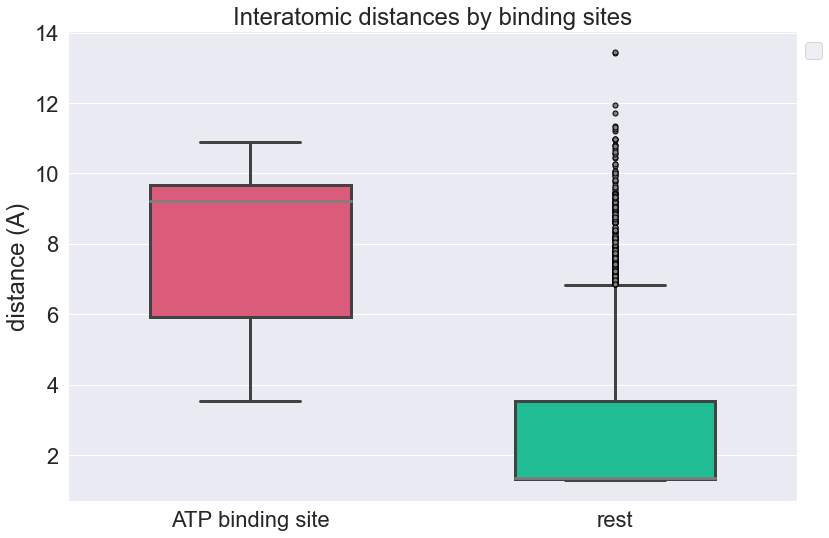

In [25]:
# Now plot the distances for the different features: All, rest, ATP, Ca, Active site
# Summary plot
colors= ["#EF476F", "#06D6A0", "#118AB2"]
sns.set(rc={'figure.figsize':(12, 8)}, font_scale= 2)

flierprops = dict(marker='o', markerfacecolor='gray', markersize= 5,  markeredgecolor='black')
ax = sns.boxplot(data= df, x= 'entry_name', y= 'dist', width= 0.55, linewidth= 3, medianprops=dict(color="gray", alpha=0.9), palette= colors, flierprops= flierprops) # order= ['rest', ],  , notch= True , showmeans= True, meanline= True

# # Combinations to compare
# comb = combinations(summary.feature.unique(), 2)
# pairs = [ i for i in comb ]

# annotator = Annotator(ax= ax, pairs= pairs, data= summary, x= 'feature', y= 'mean_score')
# annotator.configure(test= 'Mann-Whitney', text_format='star')
# annotator.apply_and_annotate()


#plt.rcParams['font.size'] = 16
plt.title("Interatomic distances by binding sites") # f" in {msa}
plt.ylabel("distance (A)")
plt.xlabel("")
plt.legend(loc= 1,  bbox_to_anchor=(1.05, 1)) # ,  bbox_to_anchor=(1.25, 1)
plt.tight_layout()
plt.show()

---

## distances by features per MSA

In [27]:
interpro_binding_sites[interpro_binding_sites.msa == 'A5K0N4_60']

,msa,uniprot_acc,ipr_acc,start,end,entry_type,entry_name
43,A5K0N4_60,A0A0D9QPF1,IPR008271,691,703,active_site,active site
47,A5K0N4_60,A0A0L7M3I6,IPR008271,660,672,active_site,active site
51,A5K0N4_60,B6K8K4,IPR008271,803,815,active_site,active site
54,A5K0N4_60,Q7PDS2,IPR008271,590,602,active_site,active site
58,A5K0N4_60,U6MF62,IPR008271,826,838,active_site,active site
61,A5K0N4_60,W4IVK0,IPR008271,660,672,active_site,active site
145,A5K0N4_60,A5K0N4,IPR008271,653,665,active_site,active site
147,A5K0N4_60,A0A023B252,IPR008271,667,679,active_site,active site
148,A5K0N4_60,Q8I719,IPR008271,660,672,active_site,active site
10076,A5K0N4_60,A0A0D9QPF1,IPR017441,578,601,binding_site,ATP binding site


In [28]:
all_shortest_distances

,msa,pdb,pos_kd,aa_a,atom_a,pos_cre,aa_b,atom_b,dist
0,Q63450_60,1a06,111,GLY,O,285,ASN,ND2,2.839370
1,Q91YS8_60,1a06,111,GLY,O,285,ASN,ND2,2.839370
2,Q63450_60,1a06,113,TYR,O,286,ILE,N,2.824408
3,Q91YS8_60,1a06,113,TYR,O,286,ILE,N,2.824408
4,Q63450_60,1a06,107,ILE,O,287,HIS,NE2,2.719374
...,...,...,...,...,...,...,...,...,...
55859,P00533_60,8d76,795,PHE,CZ,994,ASP,O,5.704661
55860,P00533_60,8d76,848,PRO,CD,995,SER,OG,3.173897
55861,P00533_60,8d76,847,THR,CG2,996,ASN,OD1,5.863400
55862,P00533_60,8d76,795,PHE,CZ,997,PHE,C,7.585241


In [40]:
prueba = all_shortest_distances[all_shortest_distances.msa == 'Q63450_60']
prueba

,msa,pdb,pos_kd,aa_a,atom_a,pos_cre,aa_b,atom_b,dist
0,Q63450_60,1a06,111,GLY,O,285,ASN,ND2,2.839370
2,Q63450_60,1a06,113,TYR,O,286,ILE,N,2.824408
4,Q63450_60,1a06,107,ILE,O,287,HIS,NE2,2.719374
6,Q63450_60,1a06,111,GLY,O,288,GLN,N,6.045339
8,Q63450_60,1a06,213,CYS,O,289,SER,O,3.776482
10,Q63450_60,1a06,213,CYS,O,290,VAL,CA,3.698102
12,Q63450_60,1a06,108,VAL,O,291,SER,OG,3.265635
14,Q63450_60,1a06,241,TYR,CE1,292,GLU,OE2,6.065139
16,Q63450_60,1a06,213,CYS,O,293,GLN,CG,3.220397
18,Q63450_60,1a06,214,GLY,O,294,ILE,N,3.618866


No handles with labels found to put in legend.


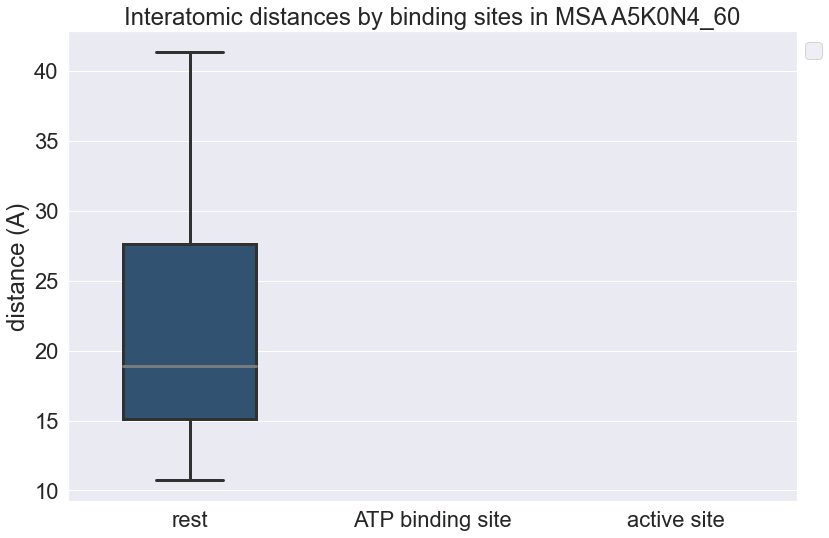

No handles with labels found to put in legend.


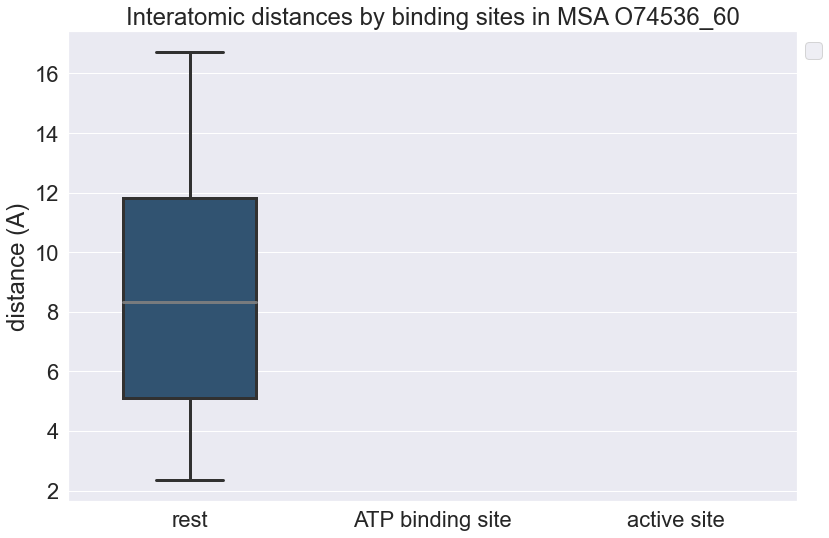

No handles with labels found to put in legend.


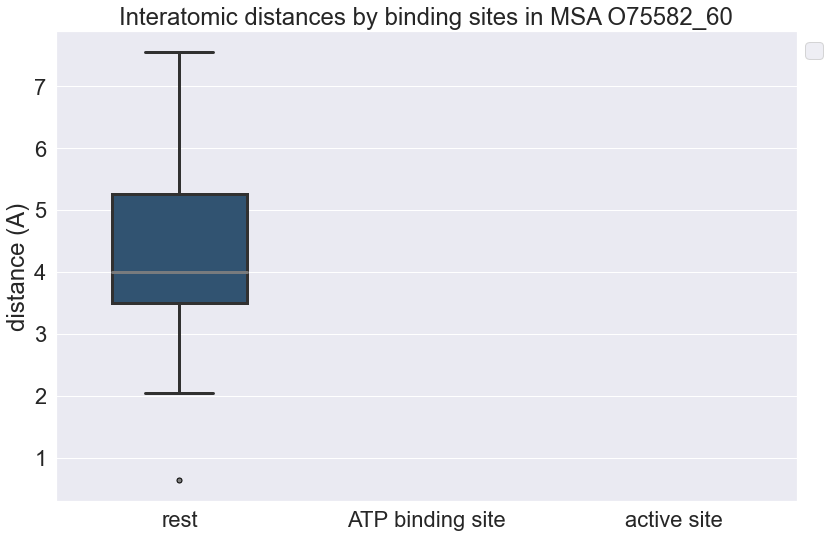

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


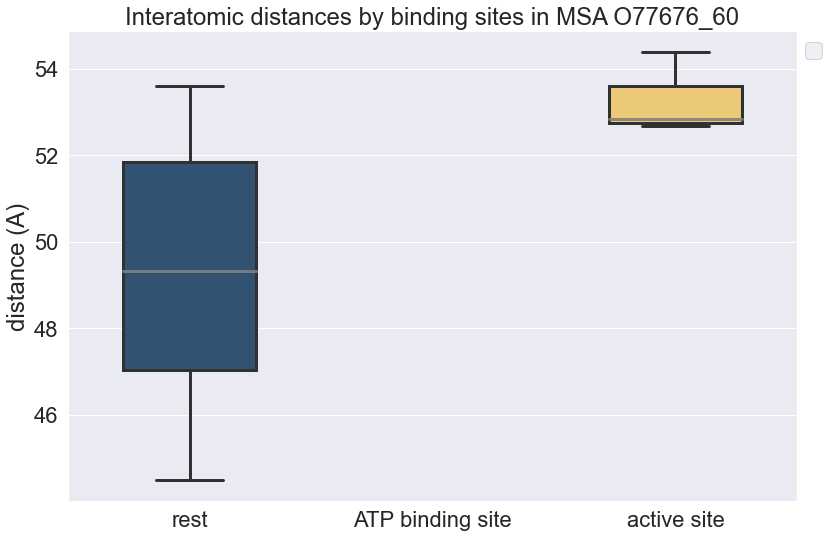

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


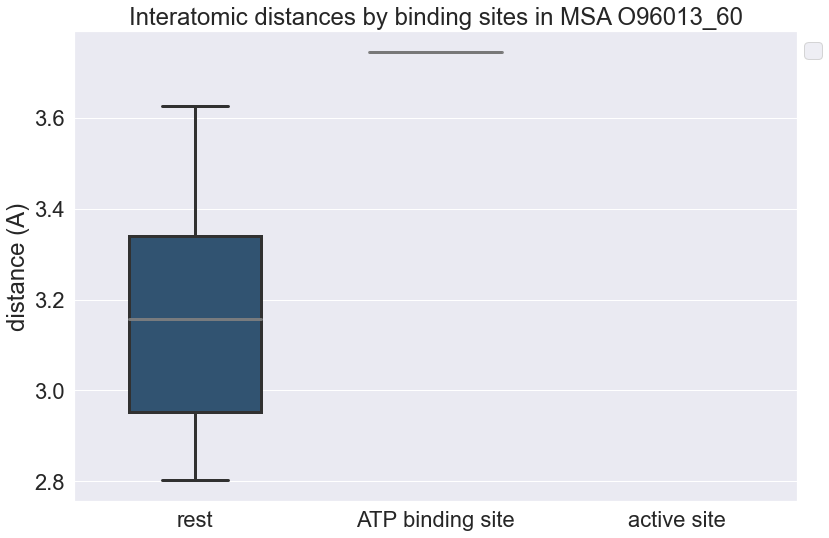

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


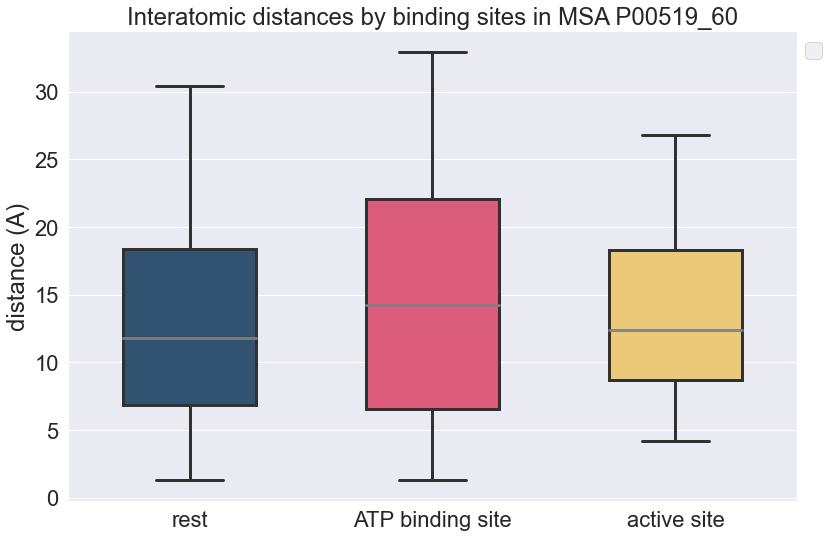

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


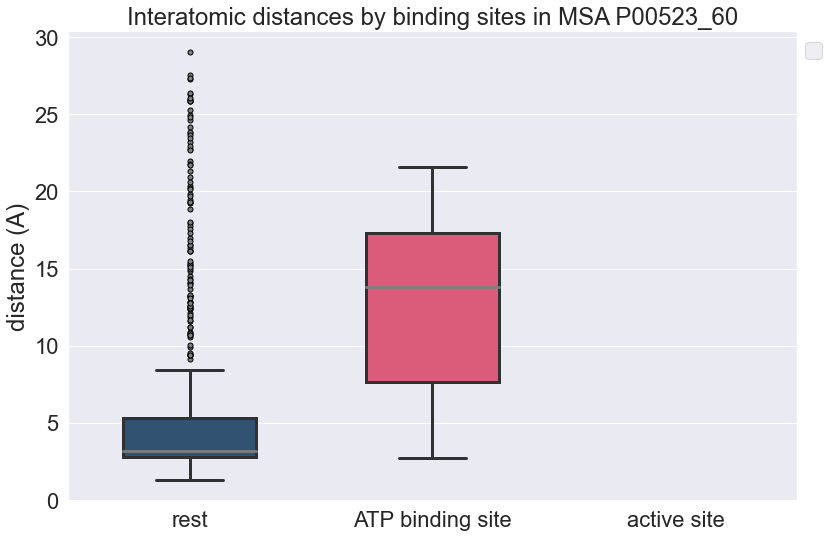

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


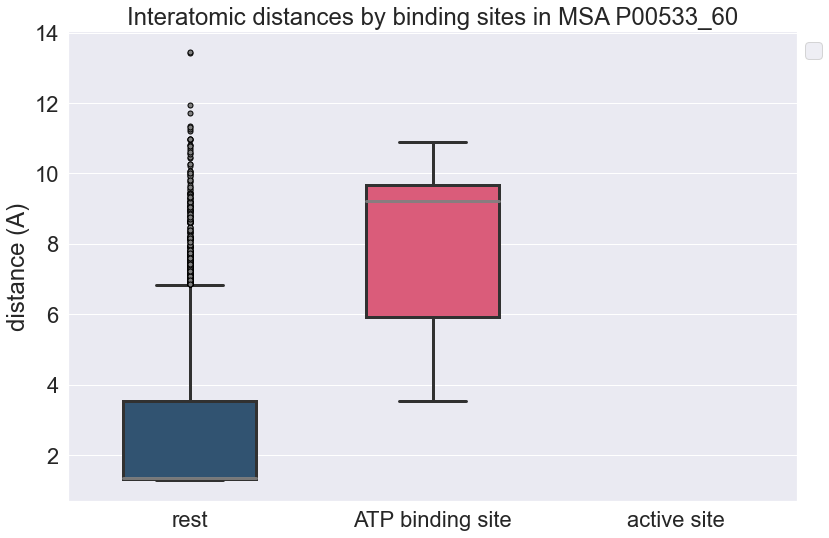

No handles with labels found to put in legend.


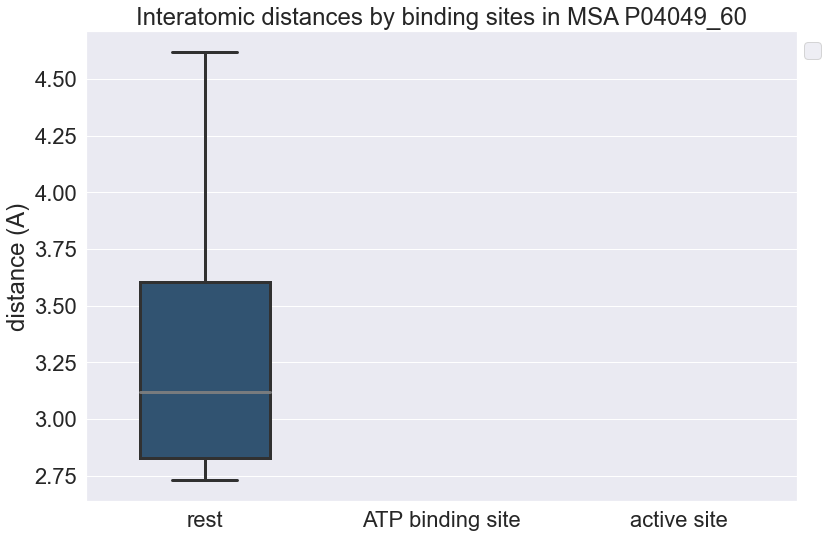

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


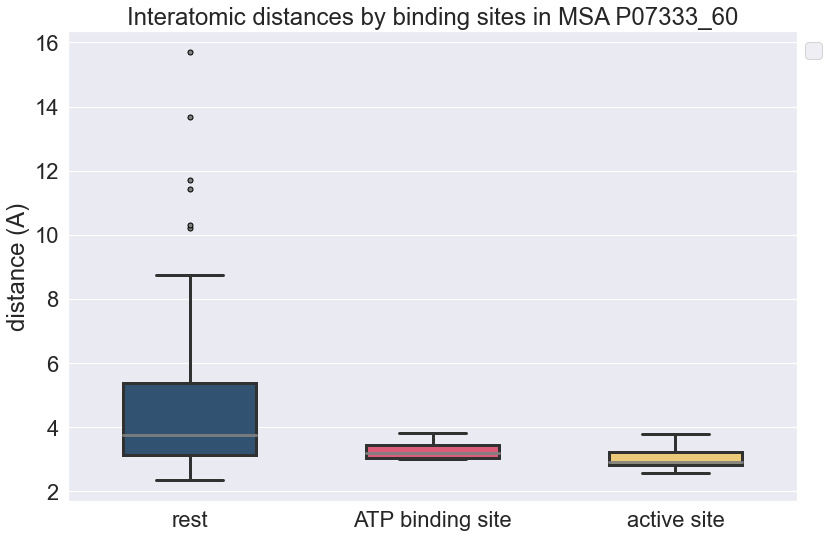

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


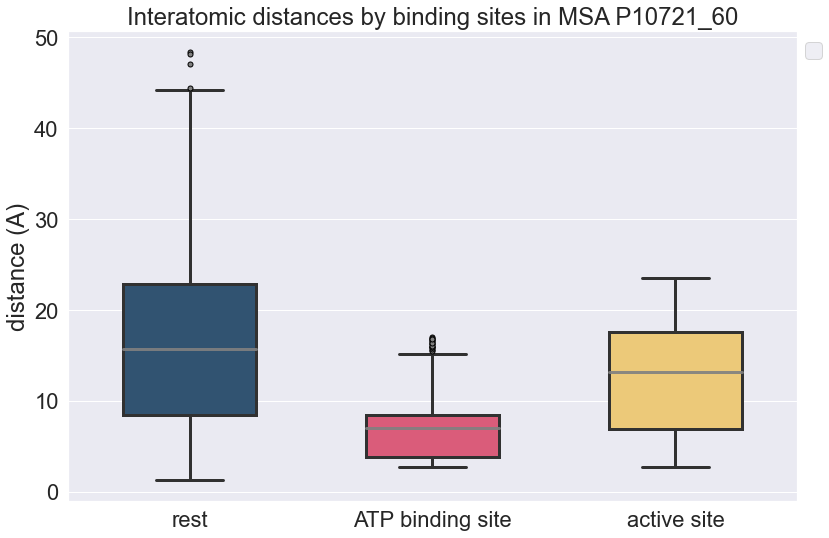

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


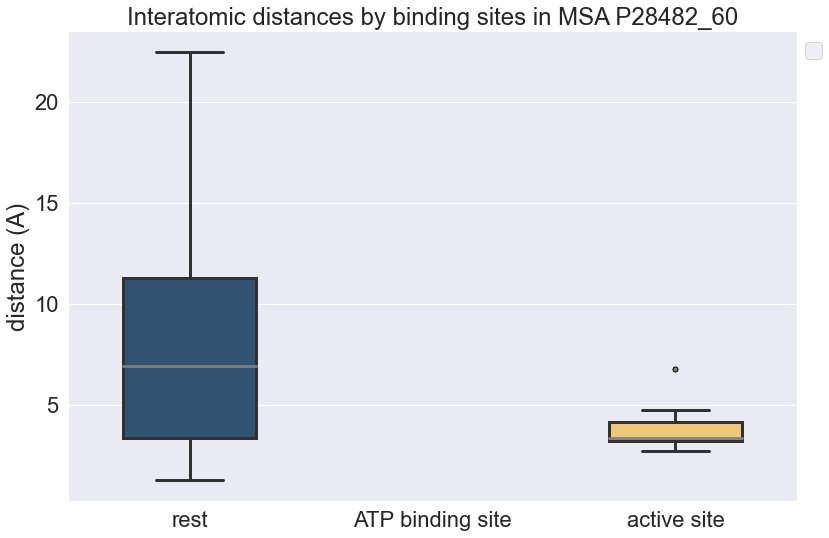

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


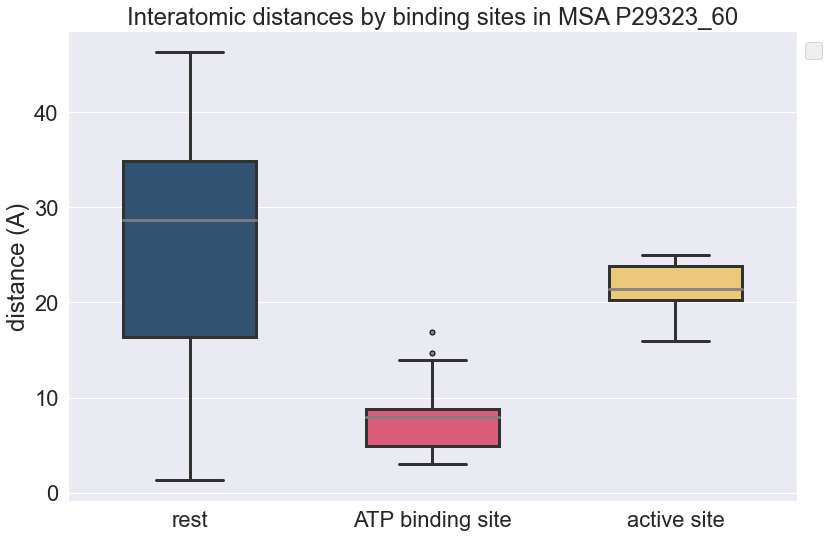

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


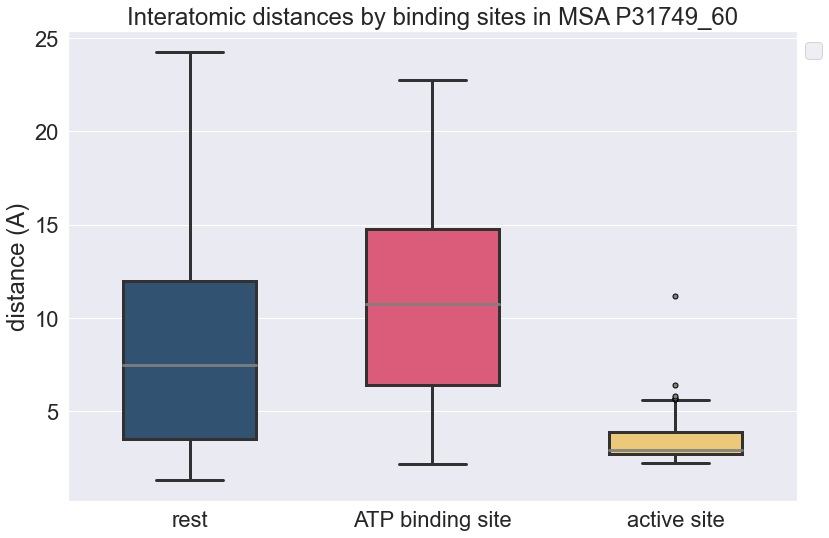

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


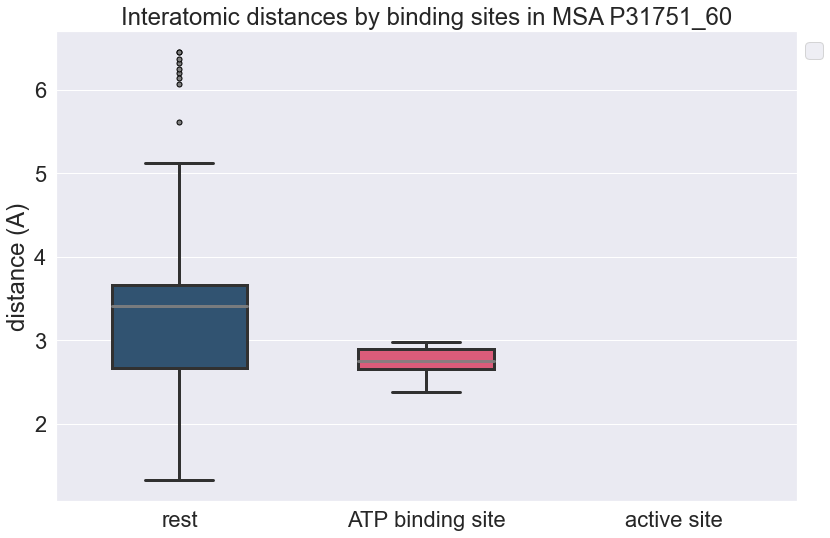

No handles with labels found to put in legend.


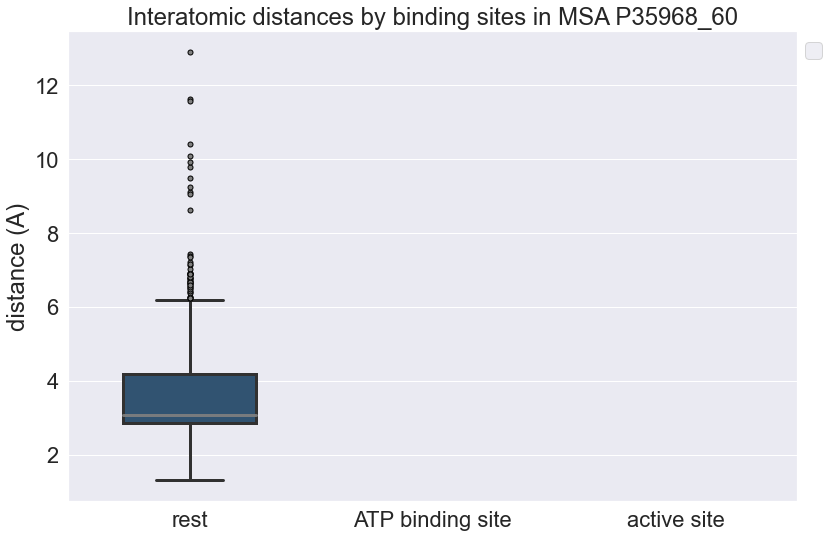

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


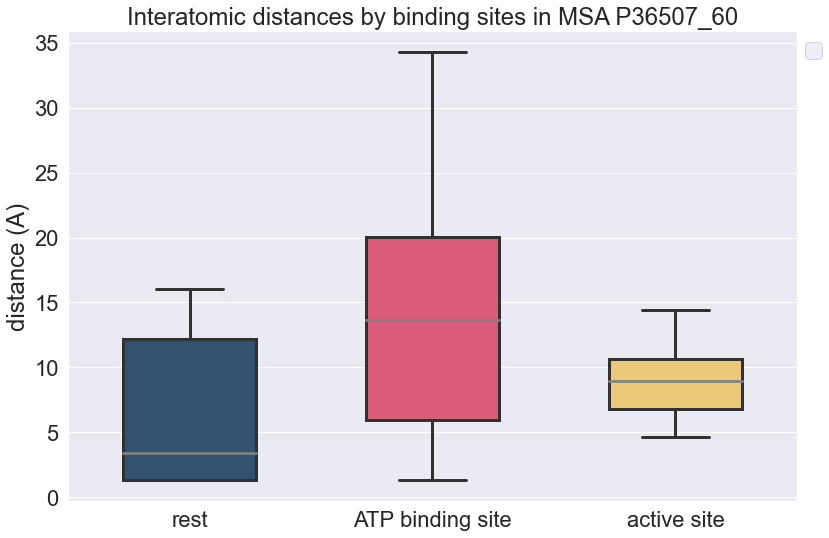

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


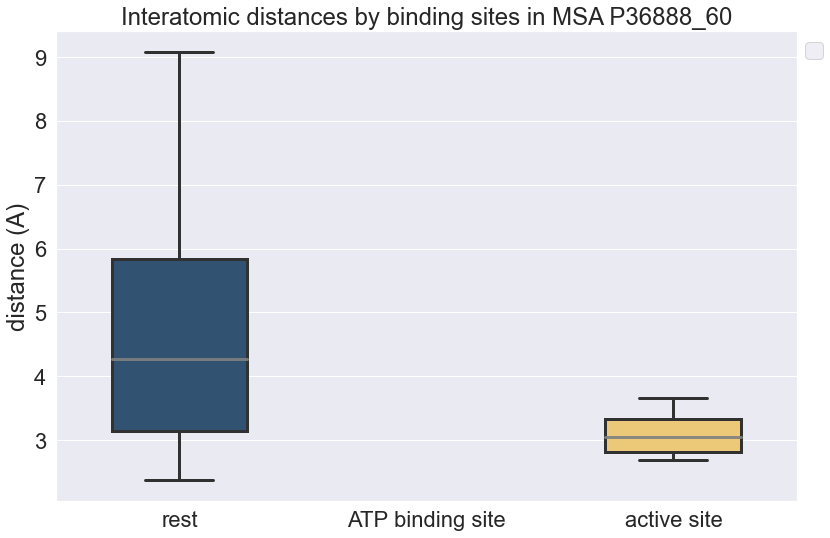

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


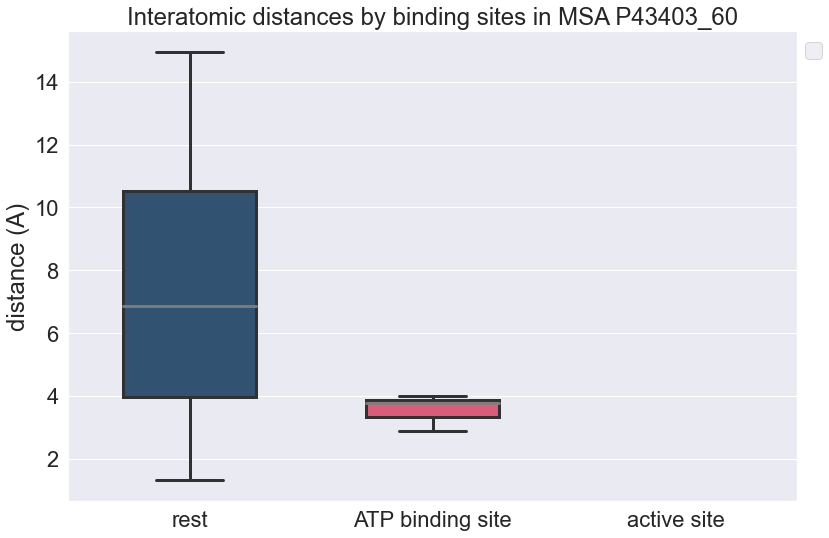

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


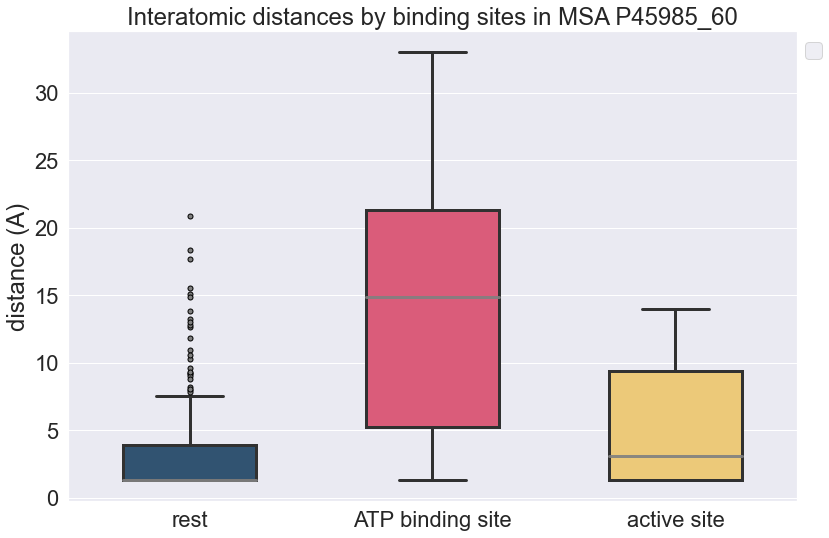

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


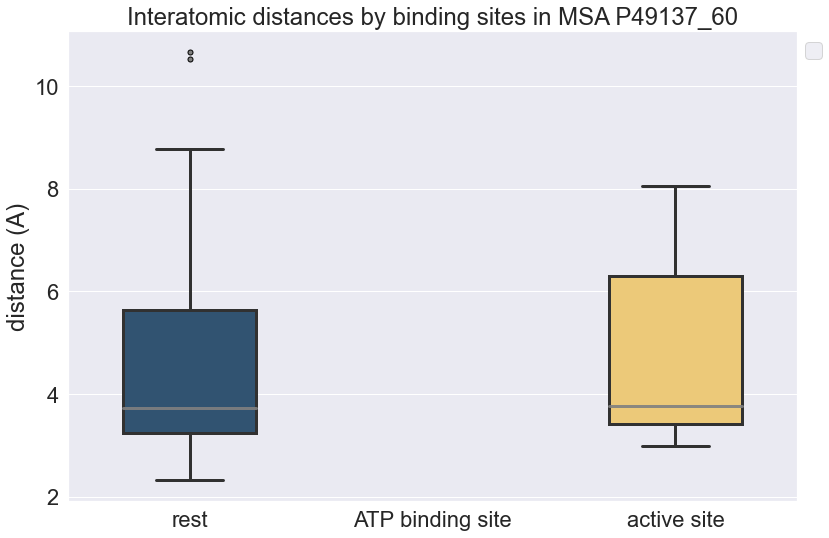

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


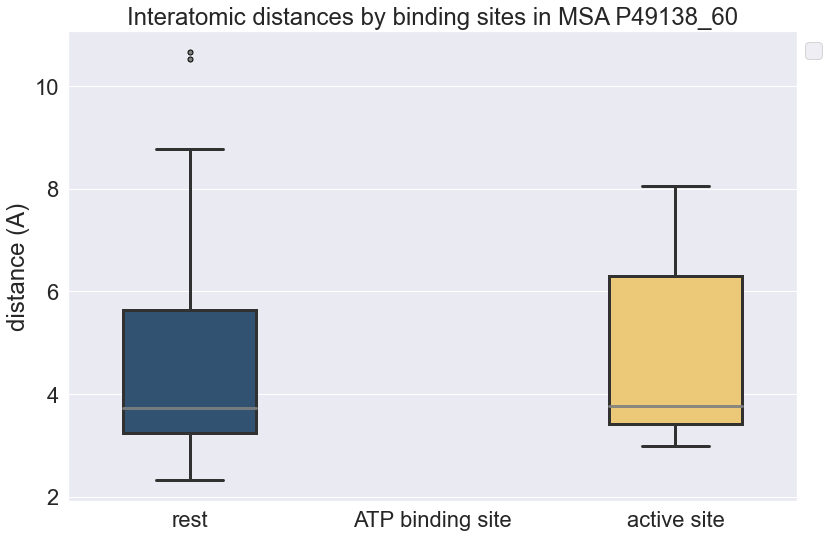

No handles with labels found to put in legend.


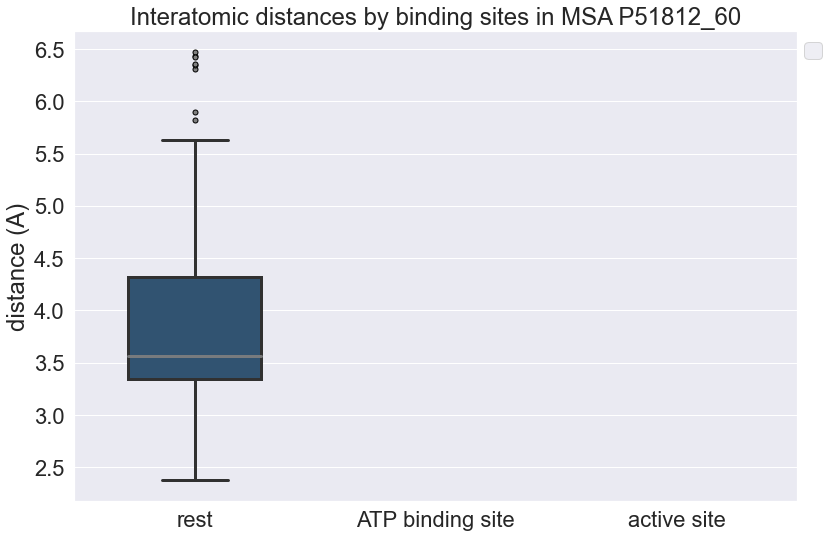

No handles with labels found to put in legend.


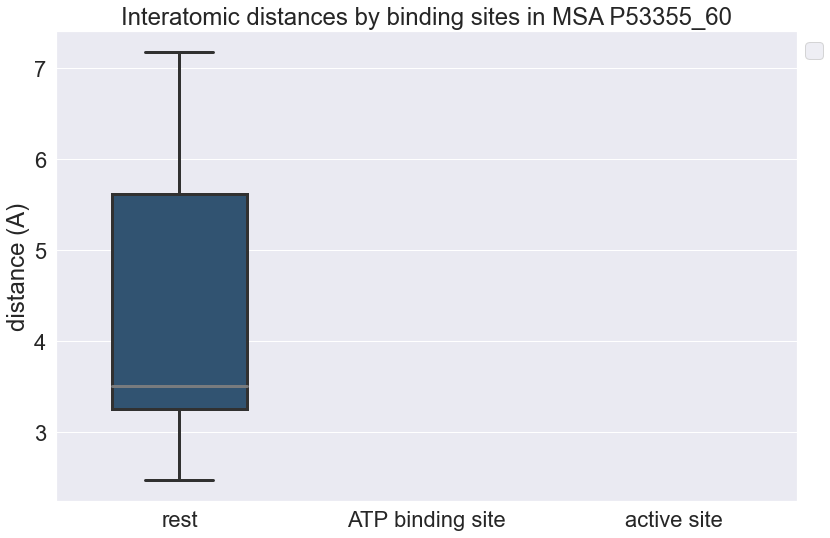

No handles with labels found to put in legend.


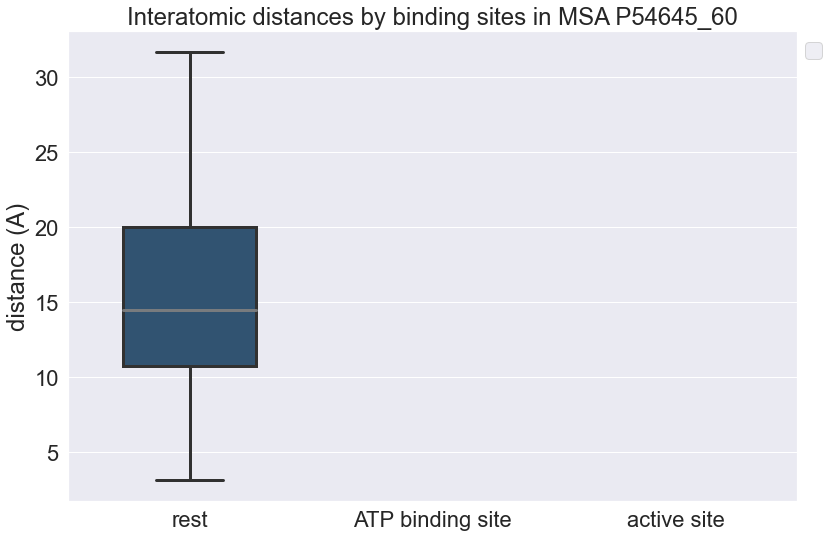

No handles with labels found to put in legend.


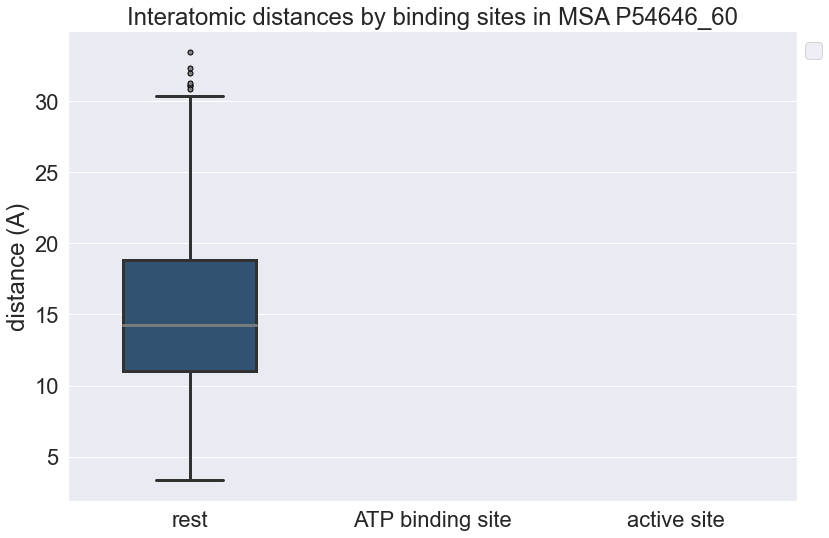

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


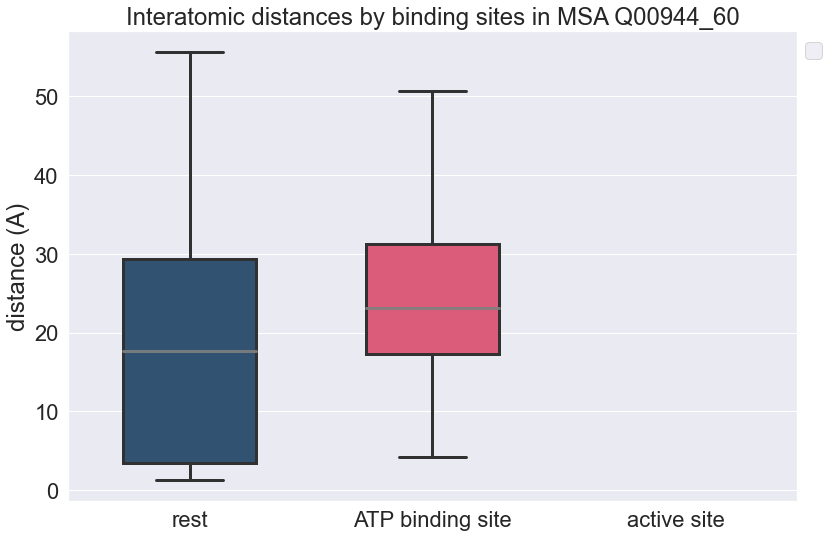

No handles with labels found to put in legend.


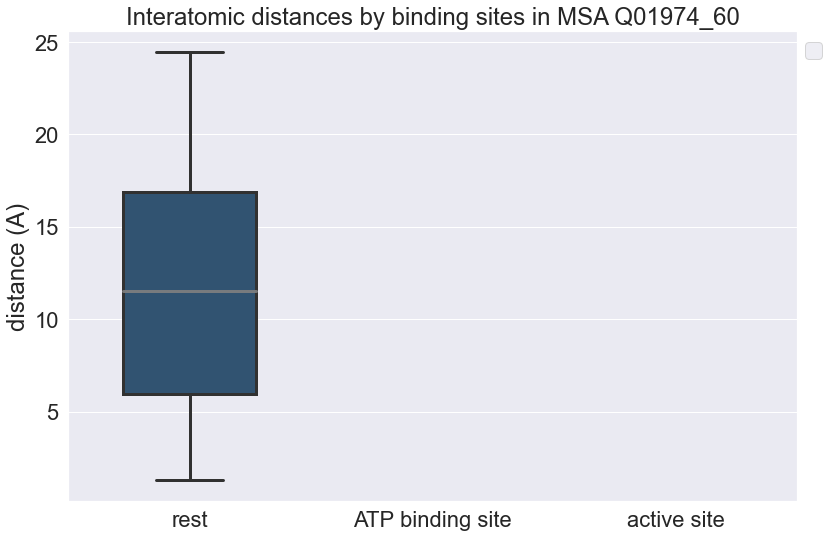

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


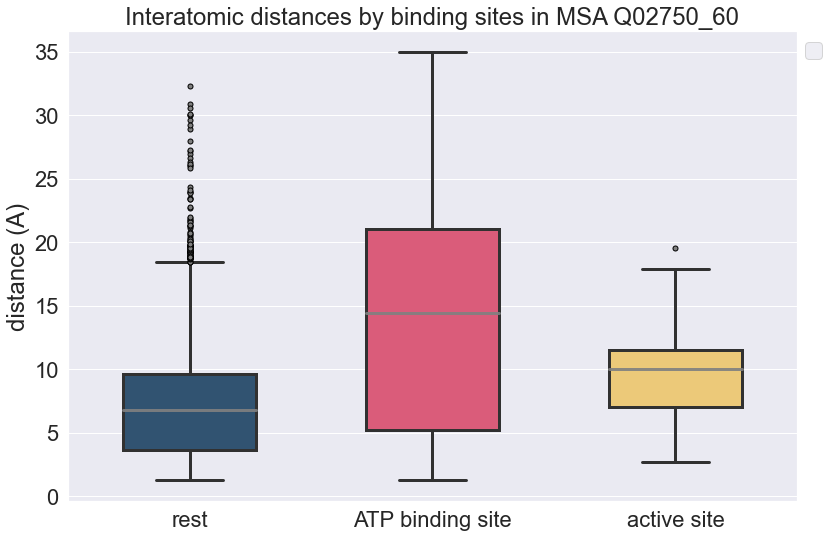

No handles with labels found to put in legend.


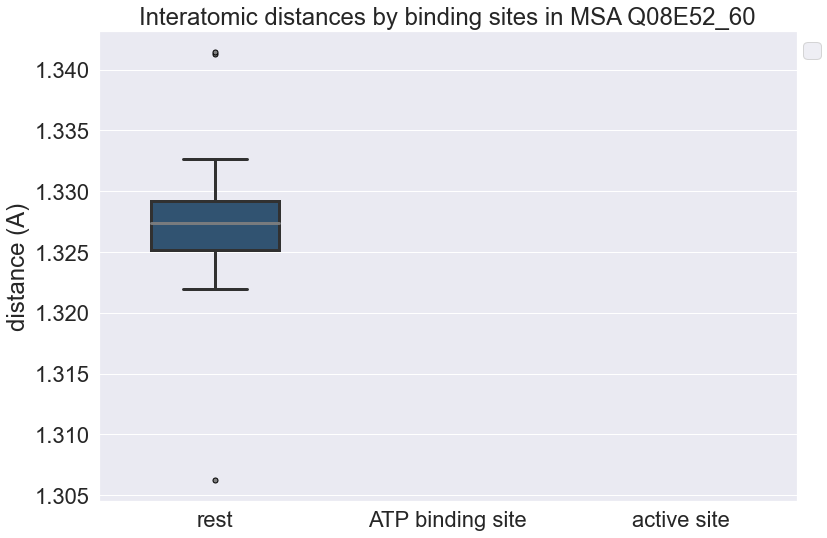

No handles with labels found to put in legend.


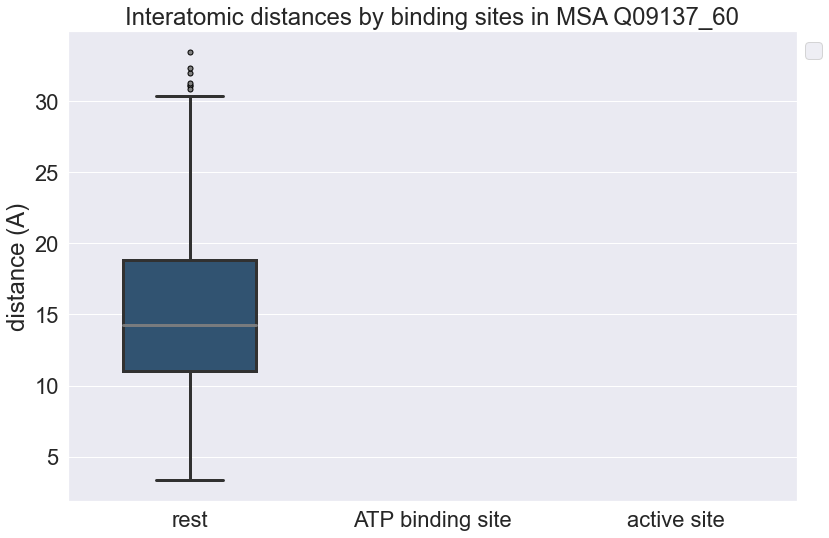

No handles with labels found to put in legend.


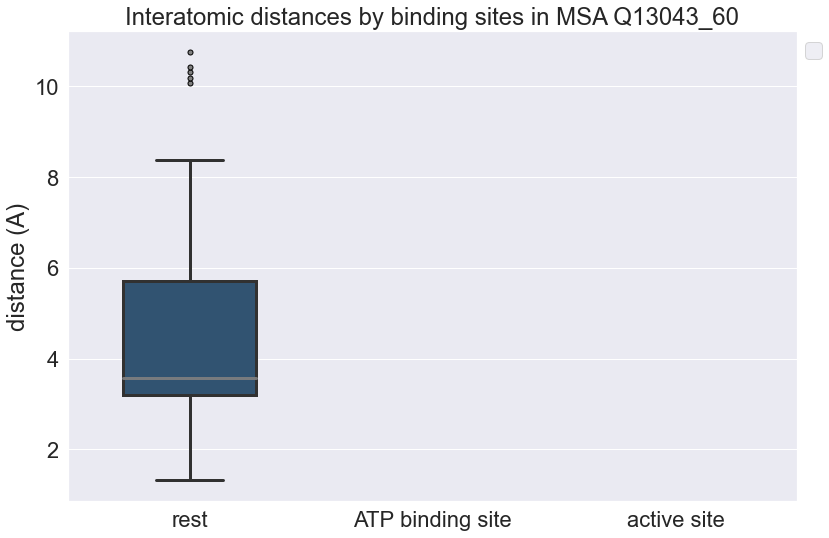

No handles with labels found to put in legend.


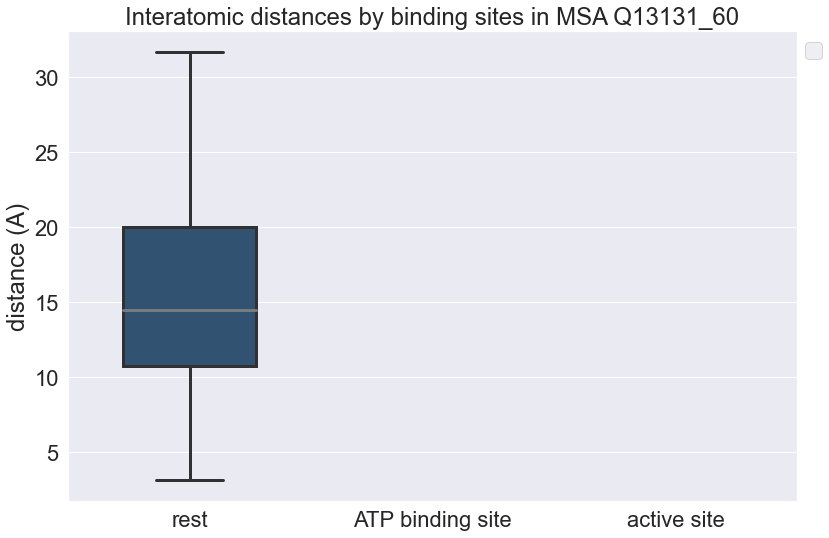

No handles with labels found to put in legend.


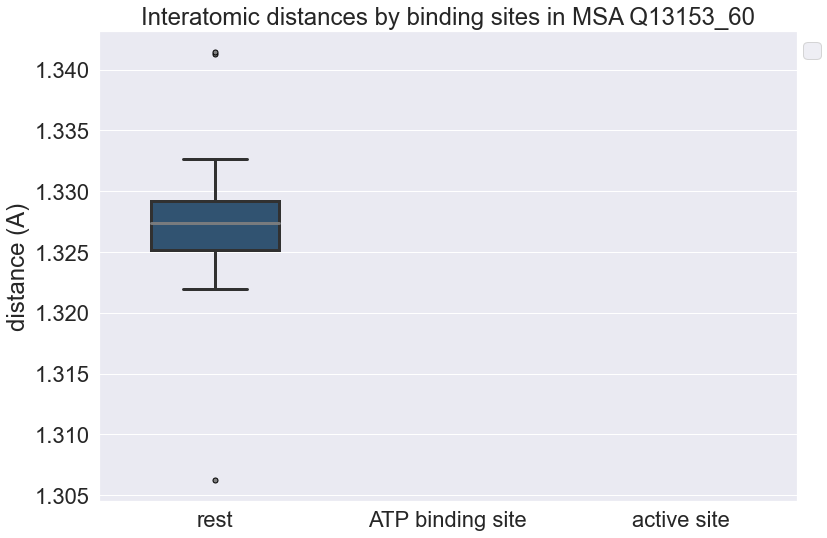

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


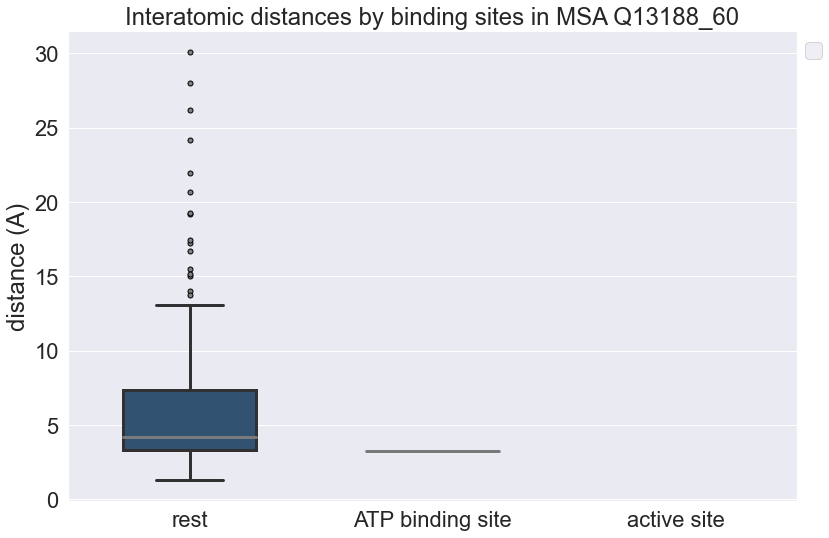

No handles with labels found to put in legend.


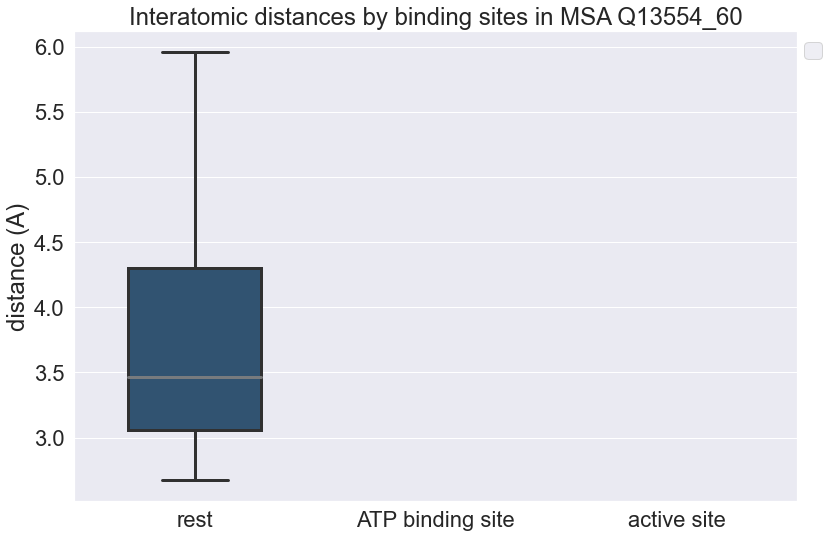

No handles with labels found to put in legend.


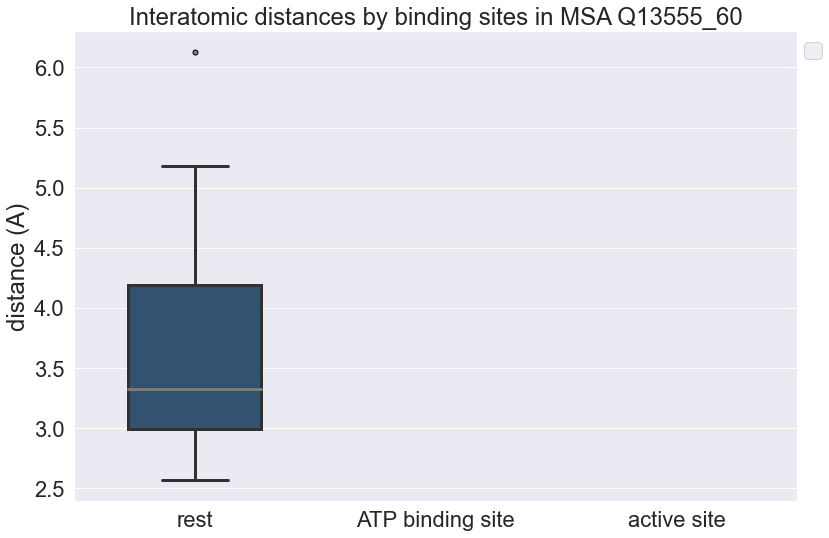

No handles with labels found to put in legend.


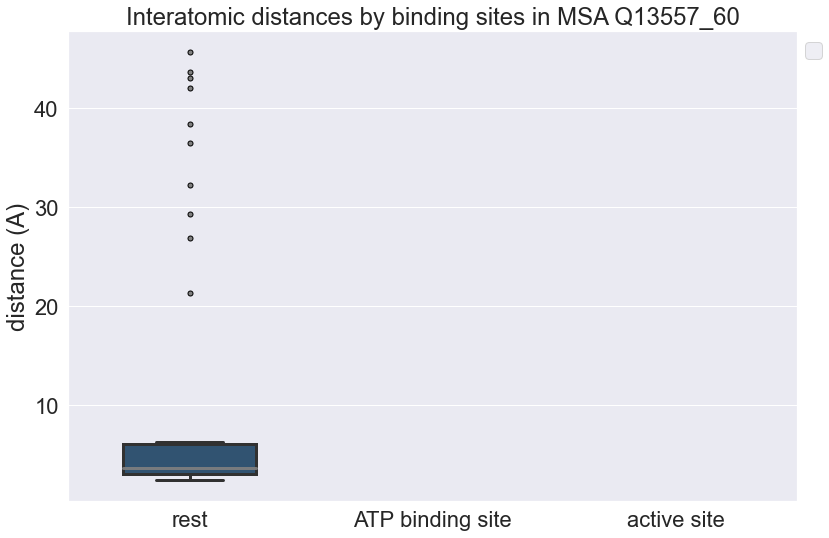

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


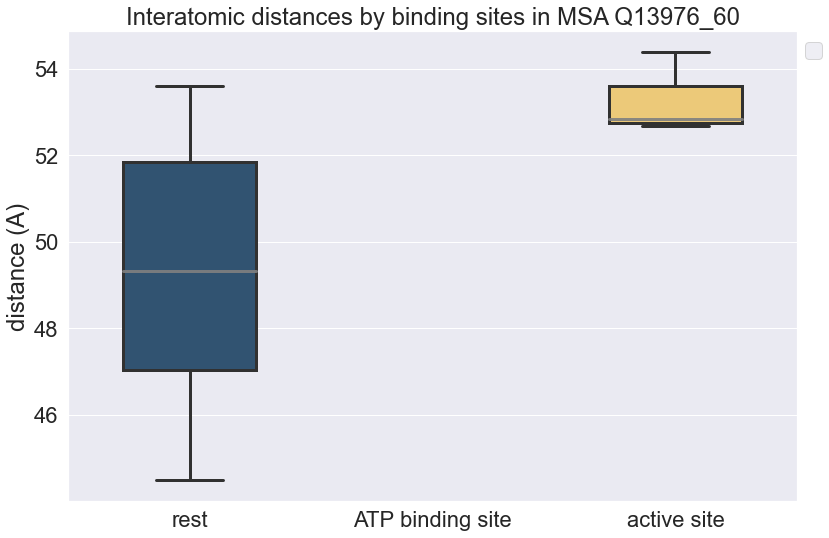

No handles with labels found to put in legend.


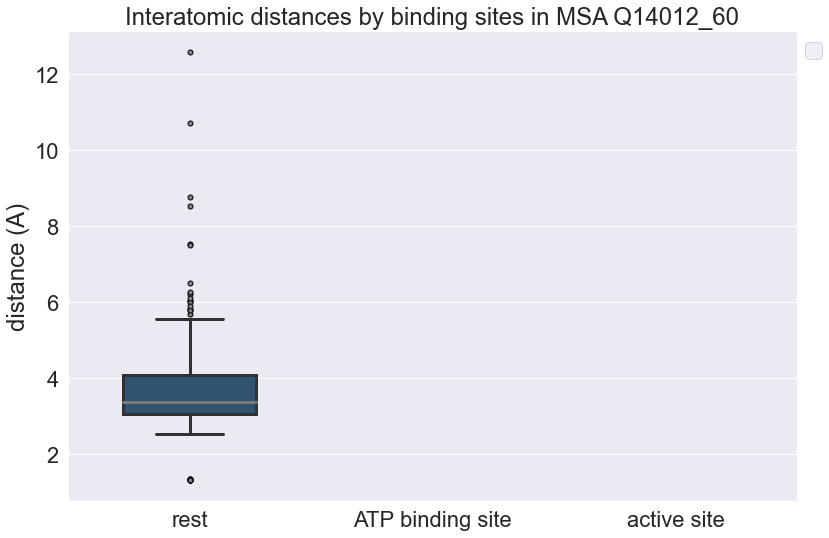

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


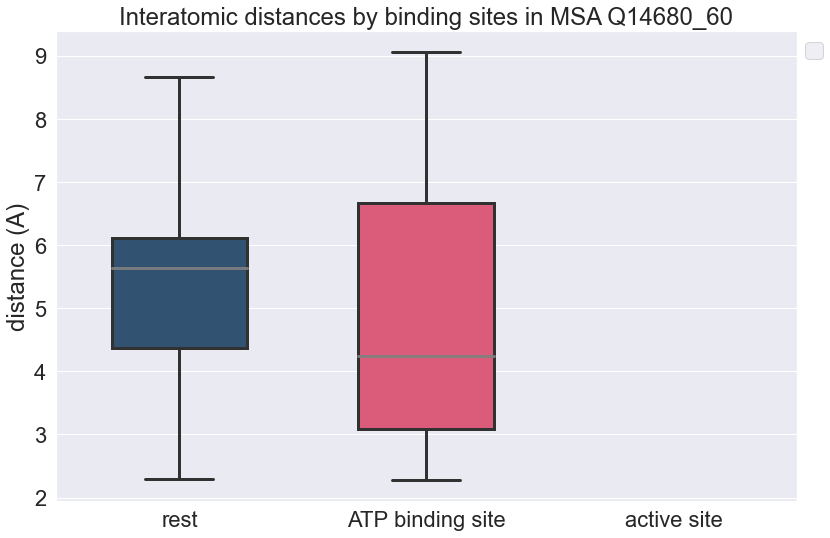

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


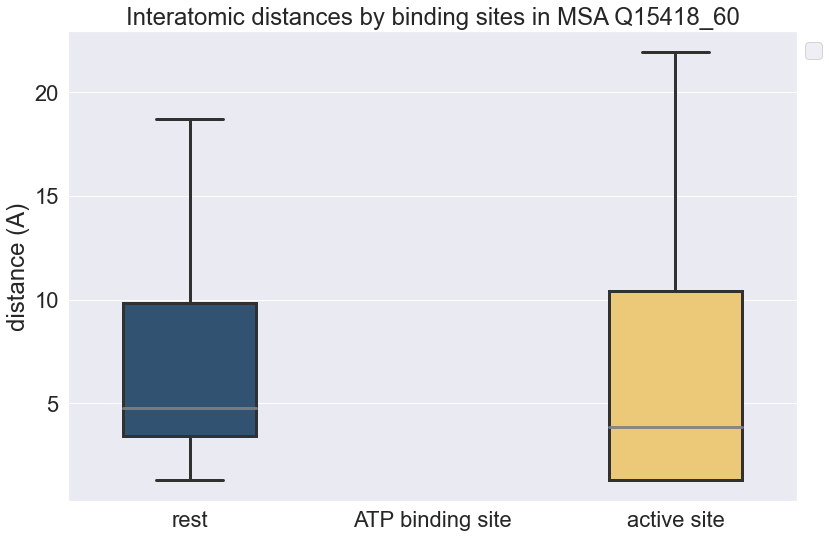

No handles with labels found to put in legend.


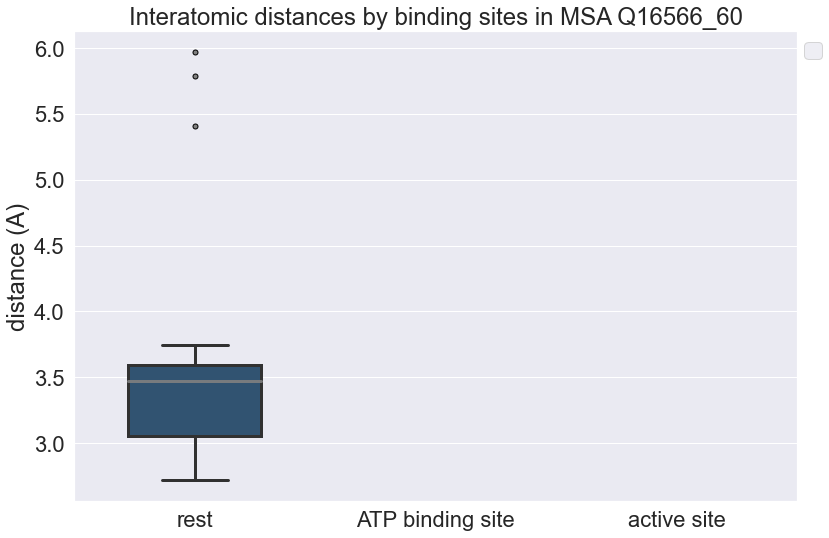

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


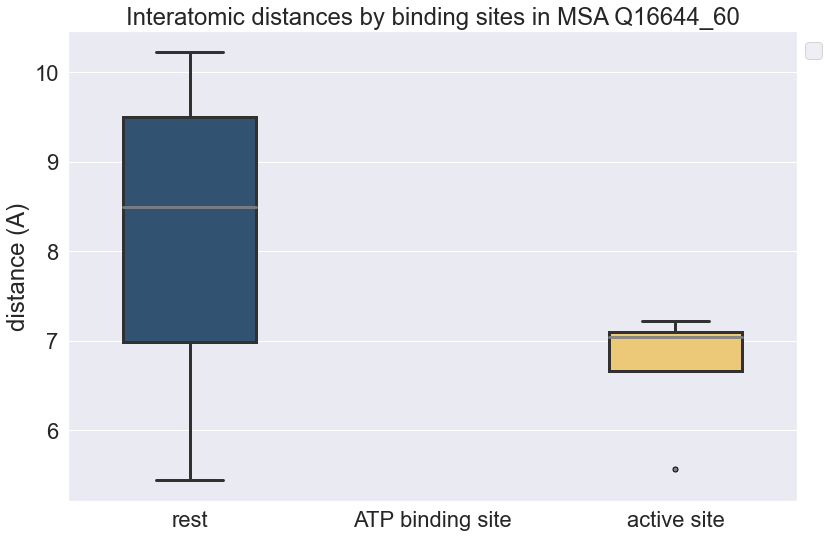

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


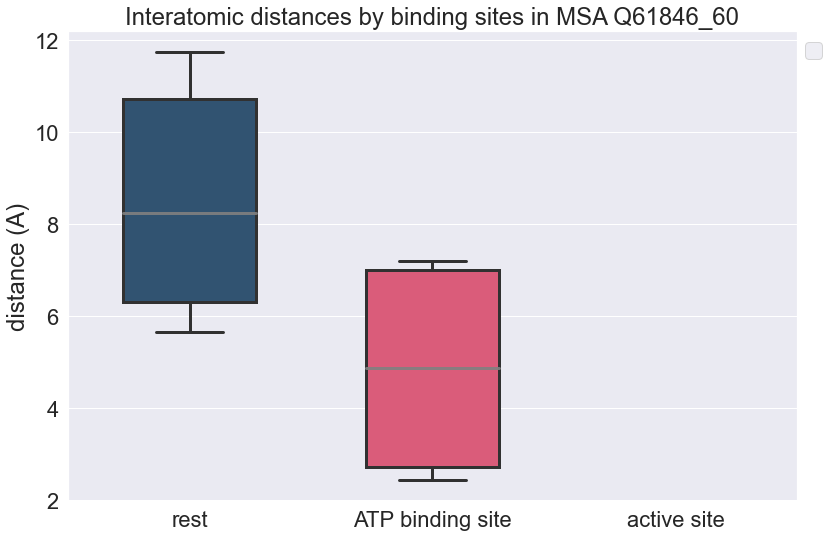

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


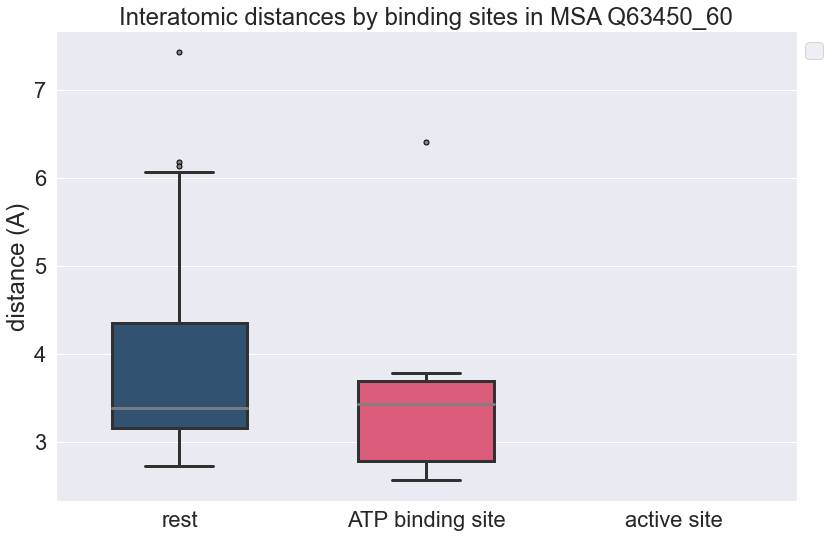

No handles with labels found to put in legend.


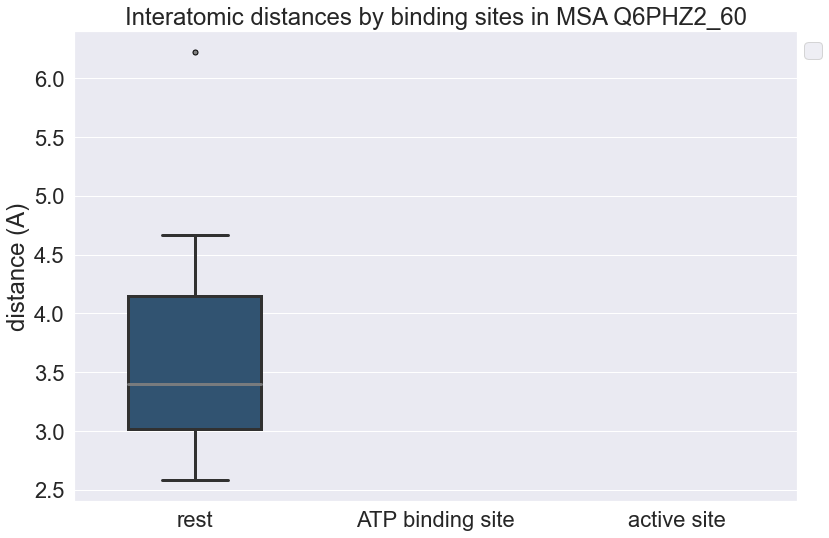

No handles with labels found to put in legend.


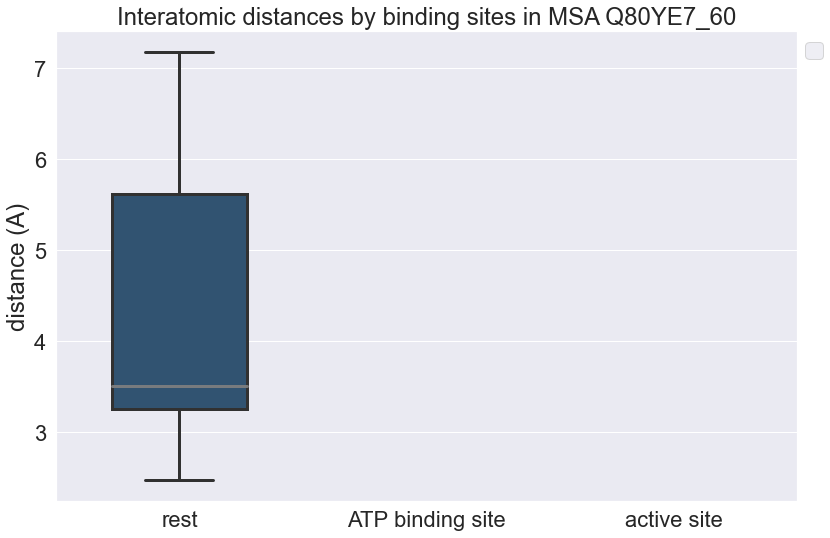

No handles with labels found to put in legend.


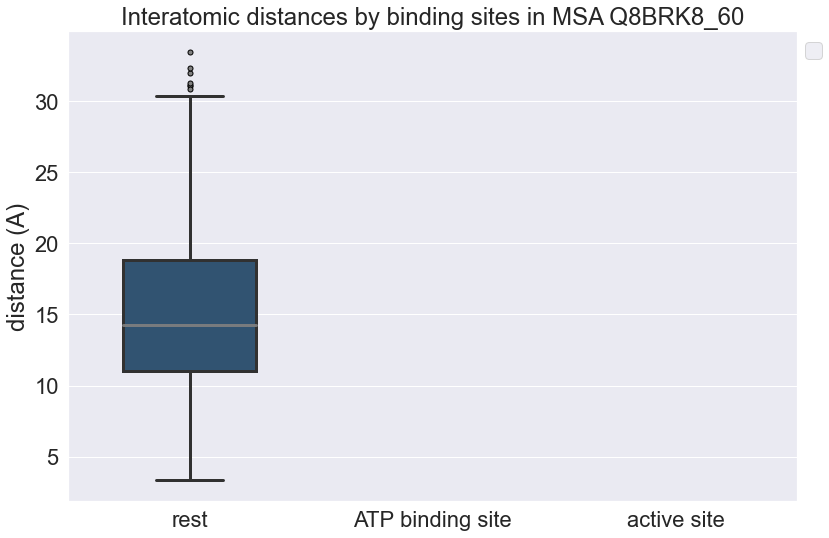

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


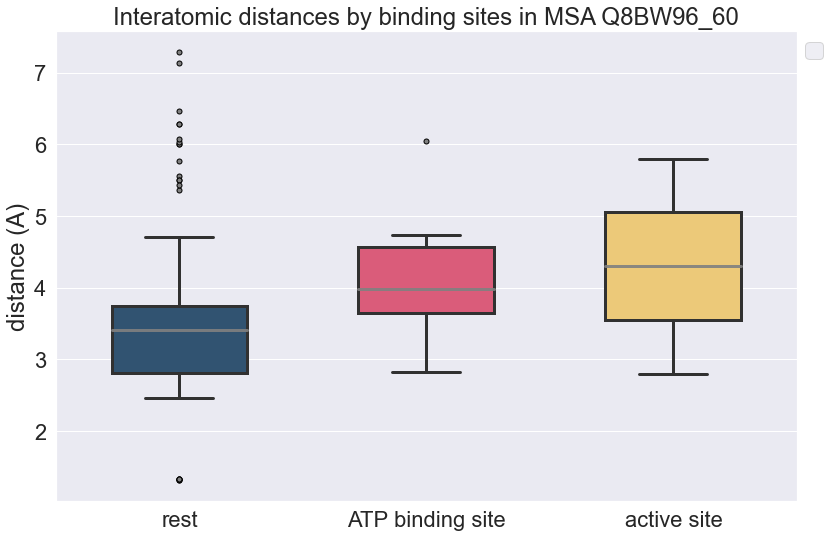

No handles with labels found to put in legend.


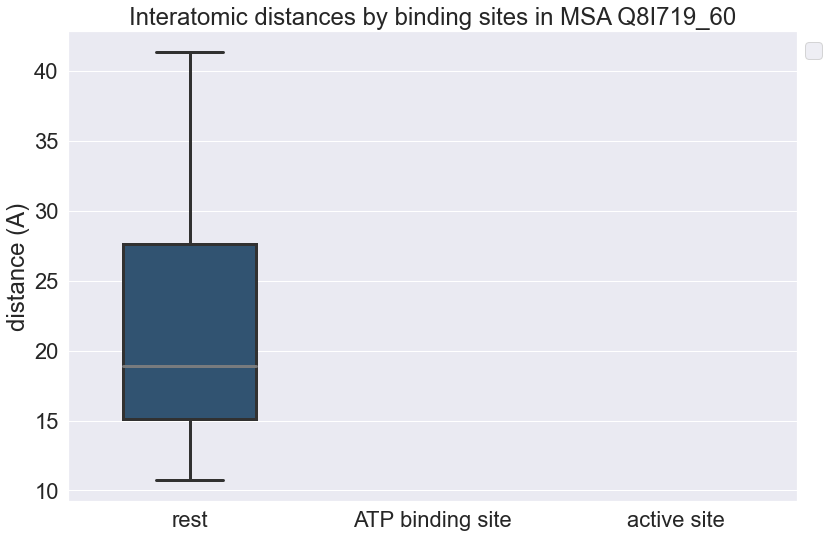

No handles with labels found to put in legend.


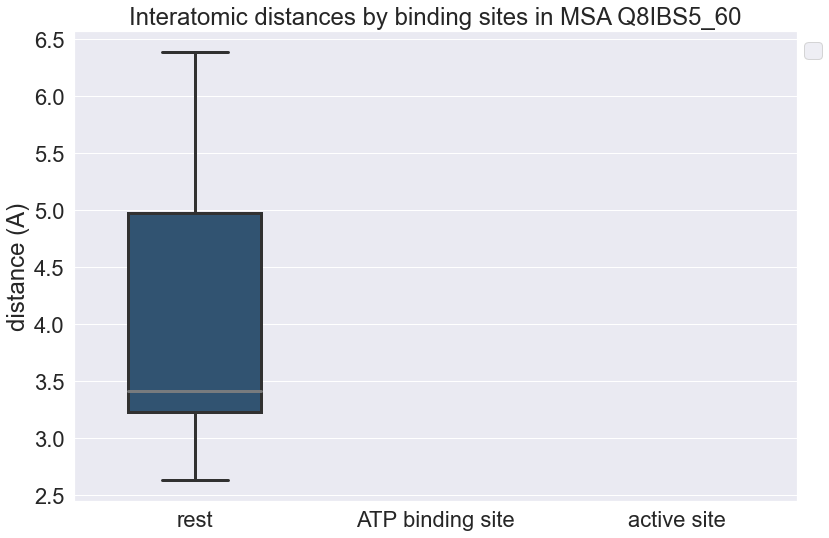

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


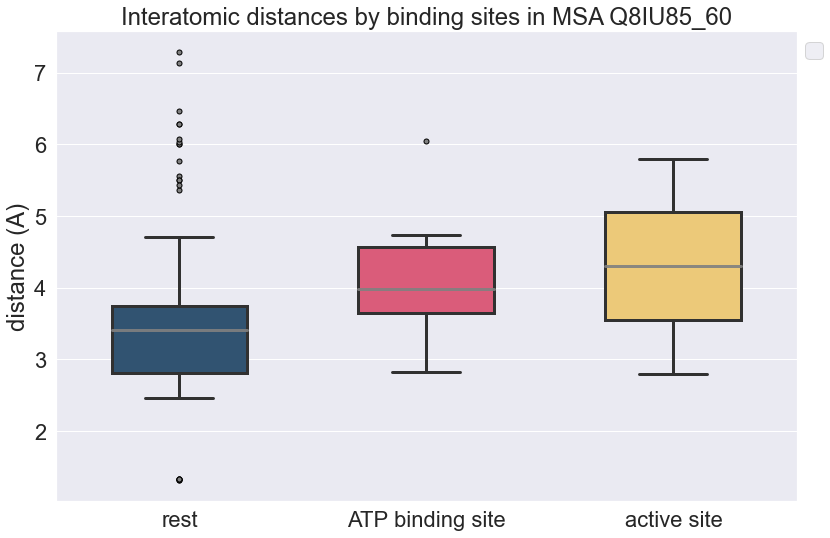

No handles with labels found to put in legend.


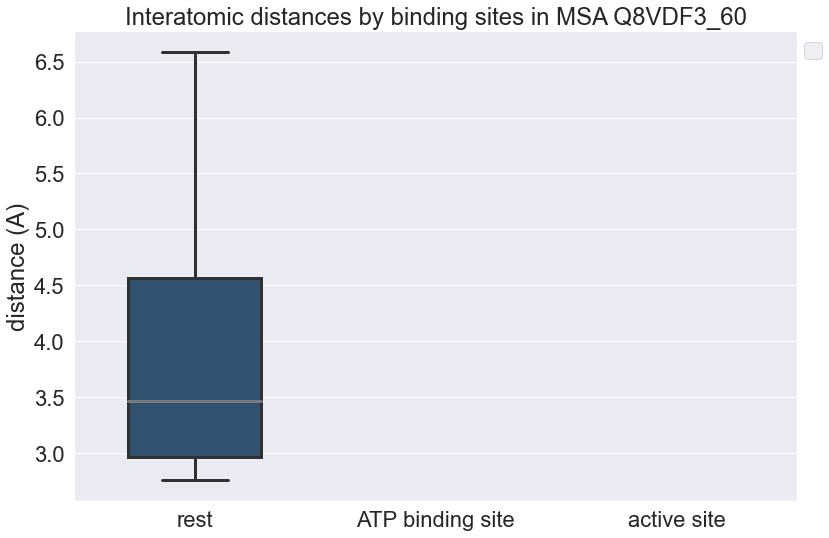

No handles with labels found to put in legend.


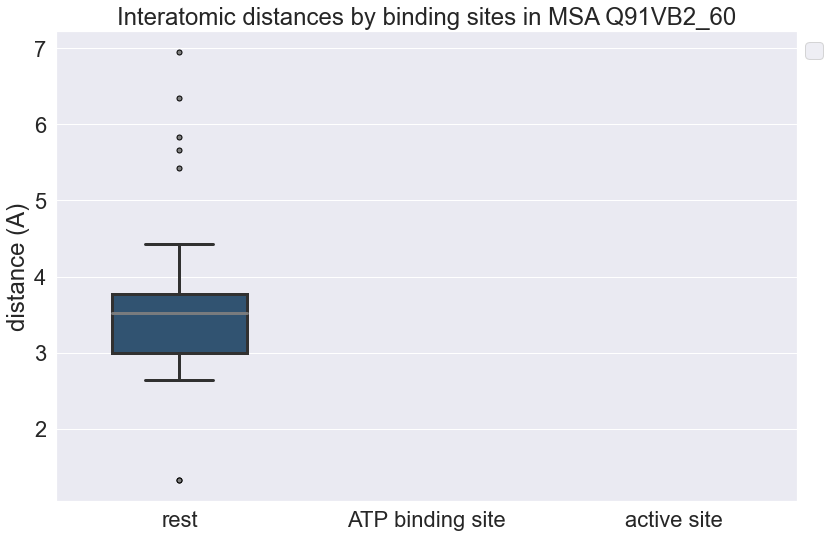

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


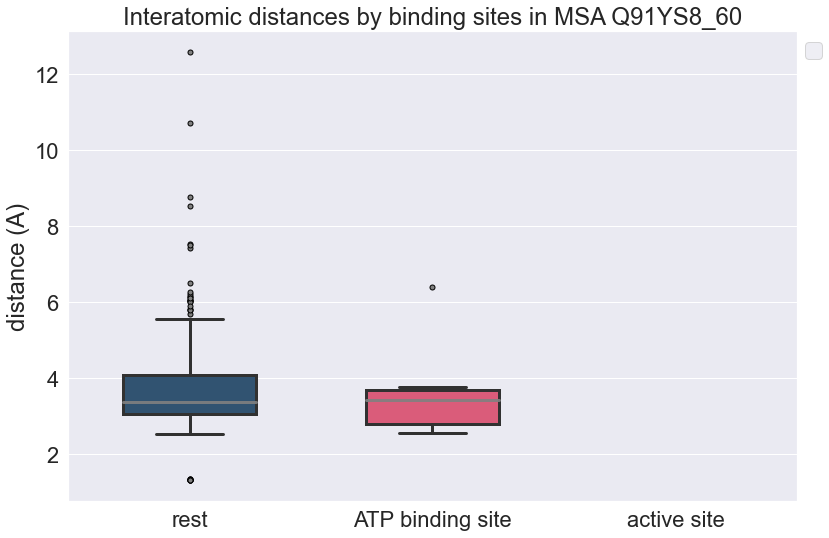

No handles with labels found to put in legend.


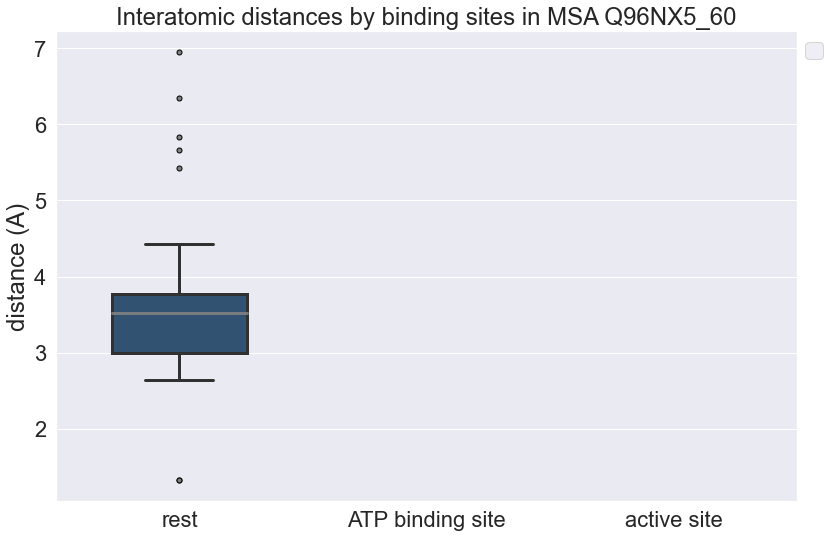

No handles with labels found to put in legend.


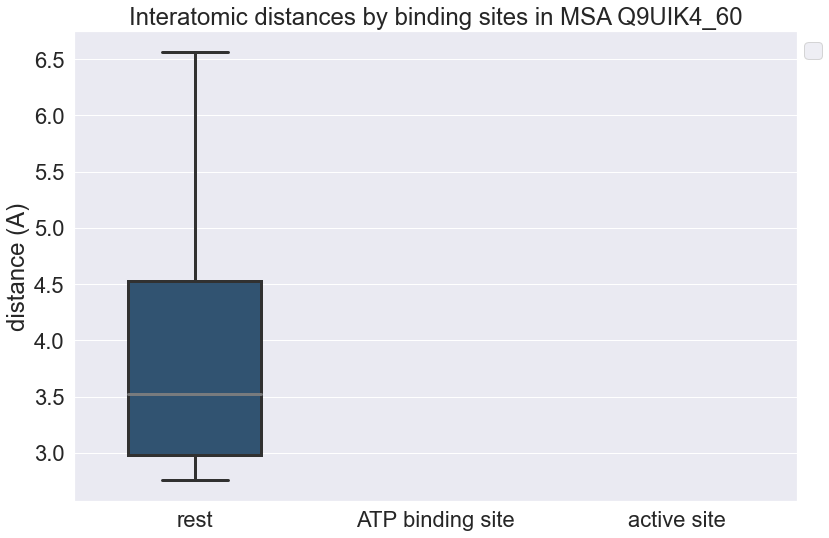

In [44]:
# Distances by MSA and features: 'rest', 'ATP binding site', 'active site'.
# I'm not considering the calcium binding site since they fall outside the KD

# Summary df for the aggregated plot
summary = pd.DataFrame(columns= ['msa', 'entry_name', 'median_score', 'mean_score'])

# First, group the distances by MSA
for msa, df in all_shortest_distances.groupby("msa"):
    # Add uniprot to the distances
    df = df.merge(msa_uniprot_pdb, how= 'left')
    df = df.rename(columns= {'uniprot': 'uniprot_acc'})
    # Add distance ID
    df["id_distance"] = range(1, df.shape[0]+1)

    # Second, bring the binding sites for that MSA
    binding_sites = interpro_binding_sites[interpro_binding_sites.msa == msa]

    # Apply the function to each row of the Binding sites ranges
    expanded_rows = binding_sites.apply(expand_rows, axis=1) # binding_sites is a subset grouped by MSA
    # Concatenate the expanded rows
    result_df = pd.concat(expanded_rows.values, ignore_index=True) # Ok!
    result_df = result_df.drop(columns= ['entry_type']).rename(columns= {'start': 'pos'})
    
    # Check if binding sites in KD and CRE positions
    merge_kd = result_df.merge(df, left_on= ['msa', 'uniprot_acc', 'pos'], right_on= ['msa', 'uniprot_acc', 'pos_kd'])
    merge_cre = result_df.merge(df, left_on= ['msa', 'uniprot_acc', 'pos'], right_on= ['msa', 'uniprot_acc', 'pos_cre'])
    # if these df are empty is because there are no distance measure for those positions. 
    # That can be because the pdb has no info at those positions


    # Concat both tables and drop duplicates
    binding_sites_distances = pd.concat([merge_kd, merge_cre]).drop_duplicates()
    # Drop cases where pos_kd = pos_cre
    binding_sites_distances = binding_sites_distances[binding_sites_distances.pos_kd != binding_sites_distances.pos_cre]

    # Now a df with all distances
    to_concat = binding_sites_distances[['msa', 'uniprot_acc', 'pdb', 'pos', 'entry_name', 'pos_kd',
        'aa_a', 'atom_a', 'pos_cre', 'aa_b', 'atom_b', 'dist', 'id_distance']]
    
    # finally add rest, that are distances that has no binding site annotation
    rest = df[~df.id_distance.isin(binding_sites_distances.id_distance)]
    rest["entry_name"] = 'rest'
    rest["pos"] = 0

    df = pd.concat([to_concat, rest])

    # For each MSA, store the median and mean values
    for entry_name, group in df.groupby("entry_name"):
        entry = pd.DataFrame(data = {'msa': msa, 'entry_name': entry_name, 'median_score':  group.dist.median(), 'mean_score': group.dist.mean() }, index= [0] )
        summary = pd.concat([summary, entry])

    # Now plot the distances for the different features: rest, ATP, Active site
    colors= ['#26547c', '#ef476f', '#ffd166', '#06d6a0']
    sns.set(rc={'figure.figsize':(12, 8)}, font_scale= 2)

    features = ['rest', 'ATP binding site', 'active site']
    flierprops = dict(marker='o', markerfacecolor='gray', markersize= 5,  markeredgecolor='black')
    ax = sns.boxplot(data= df, x= 'entry_name', y= 'dist', order= features, width= 0.55, linewidth= 3, medianprops=dict(color="gray", alpha=0.9), palette= colors, flierprops= flierprops) # order= ['rest', ],  , notch= True , showmeans= True, meanline= True

    # # Combinations to compare
    # comb = combinations(df.entry_name.unique(), 2)
    # pairs = [ i for i in comb ]

    # annotator = Annotator(ax= ax, pairs= pairs, data= df, x= 'entry_name', y= 'dist')
    # annotator.configure(test= 'Mann-Whitney', text_format='star')
    # annotator.apply_and_annotate()


    #plt.rcParams['font.size'] = 16
    plt.title(f"Interatomic distances by binding sites in MSA {msa}") # f" in {msa}
    plt.ylabel("distance (A)")
    plt.xlabel("")
    plt.legend(loc= 1,  bbox_to_anchor=(1.05, 1)) # ,  bbox_to_anchor=(1.25, 1)
    plt.tight_layout()
    plt.show()


In [47]:
summary

,msa,entry_name,median_score,mean_score
0,A5K0N4_60,rest,18.874354,21.823744
0,O74536_60,rest,8.341249,8.718052
0,O75582_60,rest,3.999744,4.332814
0,O77676_60,active site,52.837521,53.300282
0,O77676_60,rest,49.330677,49.314630
...,...,...,...,...
0,Q91VB2_60,rest,3.513836,3.705016
0,Q91YS8_60,ATP binding site,3.424935,3.587429
0,Q91YS8_60,rest,3.383359,3.989840
0,Q96NX5_60,rest,3.513836,3.705016


In [49]:
summary.msa.nunique()

58

In [46]:
summary.entry_name.value_counts()

rest                58
ATP binding site    21
active site         18
Name: entry_name, dtype: int64

No handles with labels found to put in legend.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

rest vs. active site: Mann-Whitney-Wilcoxon test two-sided, P_val:4.747e-01 U_stat=4.630e+02
active site vs. ATP binding site: Mann-Whitney-Wilcoxon test two-sided, P_val:7.459e-01 U_stat=1.770e+02
rest vs. ATP binding site: Mann-Whitney-Wilcoxon test two-sided, P_val:2.328e-01 U_stat=5.010e+02


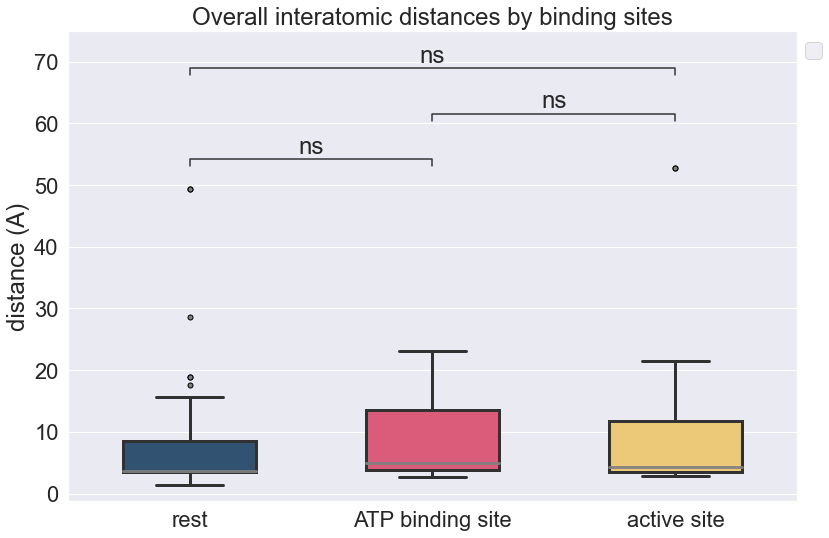

In [48]:
# Summary plot
colors= ['#26547c', '#ef476f', '#ffd166', '#06d6a0']
sns.set(rc={'figure.figsize':(12, 8)}, font_scale= 2)

features = ['rest', 'ATP binding site', 'active site']
flierprops = dict(marker='o', markerfacecolor='gray', markersize= 5,  markeredgecolor='black')
ax = sns.boxplot(data= summary, x= 'entry_name', y= 'median_score', order= features, width= 0.55, linewidth= 3, medianprops=dict(color="gray", alpha=0.9), palette= colors, flierprops= flierprops) # order= ['rest', ],  , notch= True , showmeans= True, meanline= True

# Combinations to compare
comb = combinations(summary.entry_name.unique(), 2)
pairs = [ i for i in comb ]

annotator = Annotator(ax= ax, pairs= pairs, data= summary, x= 'entry_name', y= 'median_score')
annotator.configure(test= 'Mann-Whitney', text_format='star')
annotator.apply_and_annotate()


#plt.rcParams['font.size'] = 16
plt.title("Overall interatomic distances by binding sites") # f" in {msa}
plt.ylabel("distance (A)")
plt.xlabel("")
plt.legend(loc= 1,  bbox_to_anchor=(1.05, 1)) # ,  bbox_to_anchor=(1.25, 1)
plt.tight_layout()
plt.show()

- To do: map the binding sites to in contact distances and plot it by feature (active_site, atp_binding, calcium_binding)